**Código proyecto Aprendizaje semi-supervisado basado en FixMatch**

---



Alumno: Franco Mirauda Lizana\
Profesor: Javier Ruiz del Solar\
Auxiliar: Javier Mosnaim Zegers

Fecha: 27/12/21

In [ ]:
# Importar librerías
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomAffine, RandAugment, ToPILImage, RandomPerspective, RandomCrop
import matplotlib.pyplot as plt
from random import randint
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import tensorflow as tf
import random
import torchvision.models as models
from torch import optim
from torch import nn
import sys
from torch.autograd import Variable #necesario para calcular gradientes
from copy import deepcopy
from timeit import default_timer as timer
from torch.nn.modules import conv
from torch.nn import parameter
import math
import torch.nn.functional as F

**Cargar CIFAR-10**

In [ ]:
# Transformación dataset CIFAR-10/100
tr = Compose([
    ToTensor(), 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Descarga dataset CIFAR-10
train_dataset10 = CIFAR10('/.', train=True, download=True, transform=tr)
val_dataset10_ini = CIFAR10('/.', train=False, download=True, transform=tr)
# Dividir datos de validación en validación y test (mitad):
val_dataset10, test_dataset10 = random_split(val_dataset10_ini, [5000, 5000], generator=torch.Generator().manual_seed(42))

clases10 = ('avión', 'auto', 'ave', 'gato', 'venado', 
           'perro', 'rana', 'caballo', 'barco', 'camión')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /./cifar-10-python.tar.gz to /.
Files already downloaded and verified


**Cargar CIFAR-100**

In [ ]:
# Descarga dataset CIFAR-100
train_dataset100 = CIFAR100('/.', train=True, download=True, transform=tr)
val_dataset100_ini = CIFAR100('/.', train=False, download=True, transform=tr)
# Dividir datos de validación en validación y test (mitad):
val_dataset100, test_dataset100 = random_split(val_dataset100_ini, [5000, 5000], generator=torch.Generator().manual_seed(42))

clases100 = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 
          'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
          'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 
          'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
          'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
          'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 
          'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
          'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 
          'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 
          'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 
          'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
          'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 
          'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /./cifar-100-python.tar.gz to /.
Files already downloaded and verified


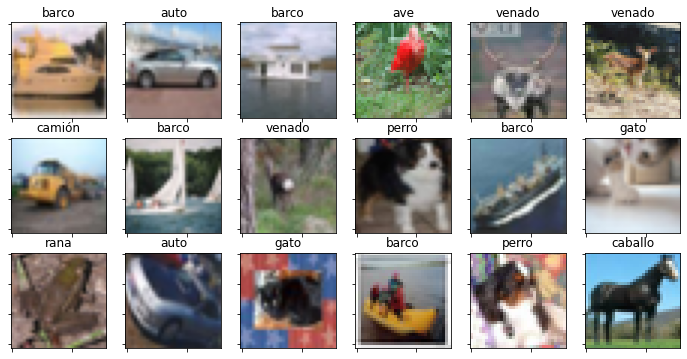

In [ ]:
# Visualización de algunas imagenes CIFAR-10
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    T, l = val_dataset10[idx]
    idx+=1
    
    # Lo siguiente es necesario para devolver los pixeles
    # a su valor original (no normalizado) y poner los canales
    # de color como última dimensión.
    T = T / 2 + 0.5


    T = T.permute(1,2,0) 
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

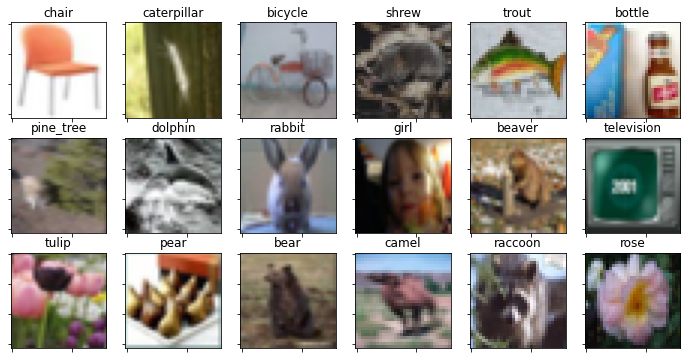

In [ ]:
# Visualización de algunas imagenes CIFAR-100
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    T, l = val_dataset100[idx]
    idx+=1
    
    # Lo siguiente es necesario para devolver los pixeles
    # a su valor original (no normalizado) y poner los canales
    # de color como última dimensión.
    T = T / 2 + 0.5
    T = T.permute(1,2,0) 
    
    img = T.numpy()
    axs[i,j].set_title(clases100[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

In [ ]:
# Se hace función para separar en 'labeled' y 'unlabeled'
def separacion(dataset, cifar = 'CIFAR10', lab_per_class = 4000, seed=0):
  
  if cifar == 'CIFAR10':
    rango = 9

  elif cifar == 'CIFAR100':
    rango = 99
  
  targets = np.array(dataset.targets)
  data = np.array(dataset.data)
  
  # Extracción de data y labels por clase
  # Caso base
  indices = np.where(targets==0)
  x = [data[i] for i in indices] 
  y = [targets[i] for i in indices]
  L_xlab = x[0][:lab_per_class]
  L_xunlab = x[0][::]
  L_ylab = y[0][:lab_per_class]
  # Se guardan etiquetas para datos no etiquetados
  # con el fin de estudiar el accuracy posteriormente
  L_yunlab = y[0][::]
  for num in range(rango):
    num+=1
    indices = np.where(targets==num)
    x = [data[i] for i in indices] 
    y = [targets[i] for i in indices]
    x_lab = x[0][:lab_per_class]
    x_unlab = x[0][::]
    y_lab = y[0][:lab_per_class]
    y_unlab = y[0][::]
    L_xlab = np.concatenate((L_xlab, x_lab), axis=0)
    L_xunlab = np.concatenate((L_xunlab, x_unlab), axis=0)
    L_ylab = np.concatenate((L_ylab, y_lab), axis=0)
    L_yunlab = np.concatenate((L_yunlab, y_unlab), axis=0)

  return L_xlab, L_ylab, L_xunlab, L_yunlab

In [ ]:
# Verificar tamaños para entrenamiento
# Se utiliza 20% de los datos de entrenamiento para datos etiquetados
etiquetas10 = 1000
etiquetas100 = 100
L_xlab10, L_ylab10, L_xunlab10, L_yunlab10 = separacion(train_dataset10, cifar = 'CIFAR10', lab_per_class = etiquetas10)
print('Largo datos etiquetados CIFAR-10:', len(L_ylab10),' Largo datos no etiquetados CIFAR-10:', len(L_xunlab10) ,' Visualización etiquetas:', L_ylab10)
L_xlab100, L_ylab100, L_xunlab100, L_yunlab100 = separacion(train_dataset100, cifar = 'CIFAR100', lab_per_class = etiquetas100)
print('Largo datos etiquetados CIFAR-100:', len(L_ylab100),' Largo datos no etiquetados CIFAR-100:', len(L_xunlab100) ,' Visualización etiquetas:', L_ylab100)

Largo datos etiquetados CIFAR-10: 10000  Largo datos no etiquetados CIFAR-10: 50000  Visualización etiquetas: [0 0 0 ... 9 9 9]
Largo datos etiquetados CIFAR-100: 10000  Largo datos no etiquetados CIFAR-100: 50000  Visualización etiquetas: [ 0  0  0 ... 99 99 99]


In [ ]:
# Dataset
# Se hace una clase para realizar el dataset considerando la opción de data augmentation
# Obs: se podría utilziar solo una clase!!! es decir, se podria eliminar la clase
# que no considera data augmentation

class My_Data(Dataset):
  def __init__(self, x, y, data_augmentation = True, weak_tr = Compose([RandomHorizontalFlip(0.5), RandomAffine(degrees = 0, translate = (0.125,0.125))]), 
               strong_tr = Compose([RandAugment(2, magnitude = 12)])):
    #self.x = x.float()
    #self.x = x
    self.x = torch.from_numpy(x).float()
    self.y = torch.from_numpy(y).long()
    self.data_augmentation = data_augmentation
    self.weak_tr = weak_tr
    self.strong_tr = strong_tr
  
  def __getitem__(self, i):
    if self.data_augmentation:
      x_w0 = self.x[i]
      x_s0 = self.x[i]
      # Weak
      x_w = self.weak_tr(x_w0)/255
      x_w = (x_w - 0.5)*2
      # Strong
      x_p = x_s0.permute(2,0,1)
      img = ToPILImage()(x_p).convert("RGB")
      x_s = self.strong_tr(img)
      x_t = ToTensor()(x_s)
      x_t = (x_t - 0.5)*2
      #x_t = x_t.permute(1,2,0) 
      return x_w.permute(2,0,1), x_t, self.y[i]
    else:
      ###
      x_i = self.weak_tr(self.x[i])/255
      x_i = (x_i - 0.5)*2
      ###
      #x_i = self.x[i]/255
      #x_i = (x_i - 0.5)*2
      return x_i.permute(2,0,1), self.y[i]
    
  def __len__(self):
    return len(self.x)

In [ ]:
# Verificar tamaño data sin aumentación
x_train10 = My_Data(L_xlab10, L_ylab10, False)
x_train100 = My_Data(L_xlab100, L_ylab100, False)
print('Largo conjunto entrenamiento CIFAR-10:', len(x_train10))
print('Largo conjunto entrenamiento CIFAR-100:', len(x_train100))

Largo conjunto entrenamiento CIFAR-10: 10000
Largo conjunto entrenamiento CIFAR-100: 10000


In [ ]:
# Mostrar imagenes sin augmented CIFAR-10
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    T, l  = x_train10[idx]
    T = T / 2 + 0.5
    idx+=1
    T = T.permute(1,2,0)
    
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

In [ ]:
# Testear tamaño data con aumentación
aug_data10 = My_Data(L_xunlab10, L_yunlab10)
print('Largo "augmented" CIFAR-10:', len(aug_data10))
aug_data100 = My_Data(L_xunlab100, L_yunlab100)
print('Largo "augmented" CIFAR-100:', len(aug_data100))       

Largo "augmented" CIFAR-10: 50000
Largo "augmented" CIFAR-100: 50000


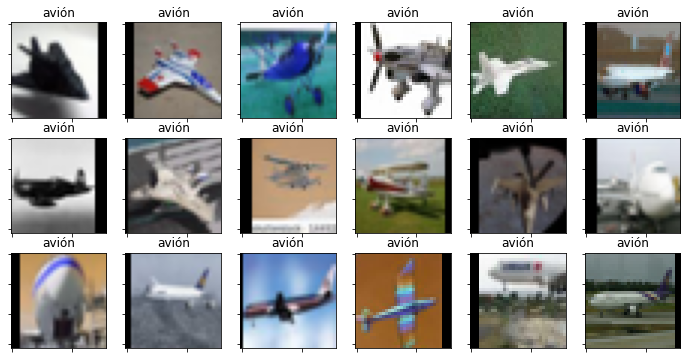

In [ ]:
# Mostrar imagenes weakly_augmented CIFAR-10
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    T, _, l = aug_data10[idx]
    T = T / 2 + 0.5
    idx+=1
    T = T.permute(1,2,0)
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

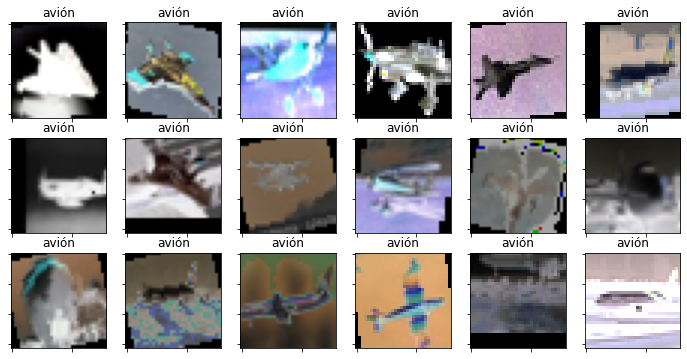

In [ ]:
# Mostrar imagenes strongly_augmented CIFAR-10 (strong augmentation 1)
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    _, T, l = aug_data10[idx]
    T = T / 2 + 0.5
    idx+=1
    T = T.permute(1,2,0)
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

In [ ]:
#Aplicar strong augmentation 2
aug_data10_2 = My_Data(L_xunlab10, L_yunlab10, strong_tr = Compose([RandAugment(1), RandomPerspective(distortion_scale=0.7, p=1.0), RandomCrop(size=(30, 30))]))
aug_data100_2 = My_Data(L_xunlab100, L_yunlab100, strong_tr = Compose([RandAugment(1), RandomPerspective(distortion_scale=0.7, p=1.0), RandomCrop(size=(30, 30))]))
# Aplicar strong augmentation 3
aug_data10_3 = My_Data(L_xunlab10, L_yunlab10, strong_tr = Compose([RandomHorizontalFlip(0.6), RandomAffine(degrees = 15, translate = (0.25,0.25))]))    
aug_data100_3 = My_Data(L_xunlab100, L_yunlab100, strong_tr = Compose([RandomHorizontalFlip(0.6), RandomAffine(degrees = 15, translate = (0.25,0.25))]))       

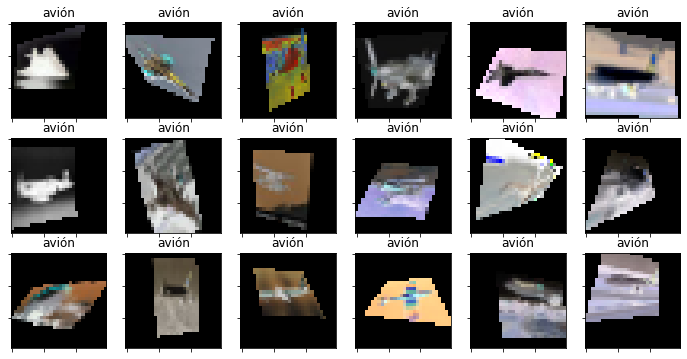

In [ ]:
# Mostrar imagenes strongly_augmented CIFAR-10 (strong augmentation 2)
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    _, T, _ = aug_data10_2[idx]
    T = T / 2 + 0.5
    idx+=1
    T = T.permute(1,2,0)
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

In [ ]:
# Mostrar imagenes strongly_augmented CIFAR-10 (strong augmentation 3)
w, h = 6, 3
fig, axs = plt.subplots(h, w, figsize=(2*w,2*h))
idx=0
for i in range(h):
  for j in range(w):
    _, T, _ = aug_data10_3[idx]
    T = T / 2 + 0.5
    idx+=1
    T = T.permute(1,2,0)
    
    img = T.numpy()
    axs[i,j].set_title(clases10[l])
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(img)

**Funciónes de entrenamiento y para graficar pérdidas**

In [ ]:
########################## Función para entrenar red ###########################
################################### BASELINE ###################################

def entrenar_red(red, loss_function, train_dataset, val_dataset, optimizador, epochs=1, batch_size=1, reports_every=1, device='cuda', stop = 2):
  #se escoge dispositivo en donde se va a entrenar (gpu o cpu)
  red.to(device)
  #inicialización del mejor loss (se escoge valor alto inicialmente)
  best_loss = 1000000
  #mediante el DataLoader se generan los batches de entrenamiento y validación
  train_data = DataLoader(train_dataset, batch_size, shuffle=True)
  val_data = DataLoader(val_dataset, 4*batch_size, shuffle=False)
  #largo del set de entrenamiento y validación
  total_train = len(train_dataset)
  total_val = len(val_dataset)
  #listas de perdida de entrenamiento y validación
  train_loss, train_acc, val_loss, val_acc = [], [], [], []
  #se inicia tiempo para encontrar mejor modelo
  start = timer()
  #definir early_stop
  early_stop = 0
  # Se define tiempo para cada epoca
  tiempo_epoca = 0
  for epoca in range(1,epochs+1):
    # Se inicializa tiempo para cada epoca
    inicio_epoca = timer()
    #asegurar que todos los parámetros se entrenarán
    red.train()
    #se inicializa el conteo de la perdida y el accuracy
    running_loss, running_acc = 0.0, 0.0
    #se generan tensores vacios para guardar mejor resultado
    Y_train = torch.tensor([]).to(device)
    Y_train_pred = torch.tensor([]).to(device)
    for i, data in enumerate(train_data):
      #se pasan datos al dispositivo correspondiente
      x_train, y_train = data
      x_train = x_train.to(device)
      y_train = y_train.to(device)

      #se inicializan los gradientes en cero
      optimizador.zero_grad()
      #se calcula predicción
      y_pred = red(x_train)

      #concatenación (para matriz de confusión)
      Y_train = torch.cat((Y_train, y_train), 0)
      Y_train_pred = torch.cat((Y_train_pred, y_pred), 0)
      #se calcula loss
      loss = loss_function(y_pred, y_train)
      #se realiza backpropagation
      loss.backward()
      #se actualiza los pesos mediante el optimizador
      optimizador.step()

      #items indica el numero de elementos entrenados
      #obs: (i+1) indica el numero de batches
      items = min(total_train, (i+1) * train_data.batch_size)
      
      #se calcula loss
      running_loss += loss.item()
      avg_loss = running_loss/(i+1)
      
      #se calcula accuracy
      _, max_idx = torch.max(y_pred, dim=1)
      running_acc += torch.sum(max_idx == y_train).item()
      avg_acc = running_acc/items*100

      #se genera reporte
      sys.stdout.write(f'\rEpoca:{epoca}({items}/{total_train}), ' 
                       + f'Train_Loss:{avg_loss:02.3f}, '
                       + f'Train_Acc:{avg_acc:02.3f}%')

    # Se actualiza tiempo para cada epoca
    tiempo_epoca += timer() - inicio_epoca
    if epoca % reports_every == 0:
      sys.stdout.write(', Validando...')
      #se agrega loss y accuracy a las listas correspondientes 
      train_loss.append(avg_loss)
      train_acc.append(avg_acc)
      #ahora se debe evaluar la red
      red.eval()
      #se inicializa el conteo de la perdida y el accuracy 
      running_loss, running_acc = 0.0, 0.0
      #se generan tensores vacios para guardar mejor resultado
      Y_val = torch.tensor([]).to(device)
      Y_val_pred = torch.tensor([]).to(device)
      for i, data in enumerate(val_data):
        #se pasan datos al dispositivo correspondiente
        x_val, y_val = data
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        y_pred = red(x_val)

        #concatenación (para matriz de confusión)
        Y_val = torch.cat((Y_val, y_val), 0)
        Y_val_pred = torch.cat((Y_val_pred, y_pred), 0)
        #se calcula loss
        loss = loss_function(y_pred, y_val)

        #items indica el numero de elementos evaluados
        #obs: (i+1) indica el numero de batches
        items = min(total_val, (i+1) *val_data.batch_size)

        #se calcula loss
        running_loss += loss.item()
        avg_loss = running_loss/(i+1)

        #se calcula accuracy
        _, max_idx = torch.max(y_pred, dim=1)
        running_acc += torch.sum(max_idx == y_val).item()
        avg_acc = running_acc/total_val*100
      
      #se agrega loss y accuracy a las listas correspondientes 
      val_loss.append(avg_loss)  
      val_acc.append(avg_acc)
      #se genera reporte
      sys.stdout.write(f', Val_Loss:{avg_loss:02.3f}, '
                       + f'Val_Acc:{avg_acc:02.3f}% ,'
                       + f'Avg-Time:{tiempo_epoca/epoca:.3f}s.\n')
      
      if avg_loss < best_loss:
        #early_stop
        early_stop = 0
        #se actualiza tiempo de entrenamiento
        end=timer()
        tiempo_entrenamiento=end-start
        #se genera mejor modelo
        best_model = deepcopy(red.state_dict())
        #se actualiza la mejor pérdida
        best_loss = avg_loss
        #se actualizan valores para matriz de confusión
        Y_train_b = Y_train
        _, Y_train_pred_b = torch.max(Y_train_pred, dim=1)
        Y_val_b = Y_val
        _, Y_val_pred_b = torch.max(Y_val_pred, dim=1)
      
      else:
        #se suma uno a early_stop
        early_stop+=1
      
    # Si early_stop sobrepasa el valor determinado se detiene el entrenamiento
    if early_stop >= stop:
      print('Early stop')
      break

    else:
      sys.stdout.write('\n')  
  
  #se imprime tiempo de entrenamiento hasta encontrar mejor modelo
  sys.stdout.write(' Tiempo entrenamiento hasta encontrar mejor modelo :{0:.3f}s '.format(tiempo_entrenamiento) )

  #se carga el mejor modelo obtenido (menor error en validación)
  red.load_state_dict(best_model)

  return train_loss, train_acc, val_loss, val_acc, Y_train_b, Y_train_pred_b, Y_val_b, Y_val_pred_b, red

In [ ]:
########################## Función para entrenar red ###########################
################################### FIXMATCH ###################################

# optimizador: - beta (momentum), etha (learning rate)
#              - weight decay:  k (current training step), K (total number of training steps)
# lam = relative weight of the unlabeled loss
# B = batch size
# tau = umbral
# mu = relative size batch unlabeled
# Obs: accuracy en los datos unlabeled que pasan el threshold en el tiempo separado por clase, 
# porcentaje del loss en la parte unlabeled, ustedes deben definir qué consideran adecuado para cuantificar qué efecto tiene el algoritmo 

def entrenar_red_fixmatch(red, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, 
                          optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 2, lr_scheduler = None):
  # Se escoge dispositivo en donde se va a entrenar (gpu o cpu)
  red.to(device)
  # Inicialización del mejor loss (se escoge valor alto inicialmente)
  best_loss = 1000000
  # Mediante el DataLoader se generan los batches de entrenamiento y validación
  # de los datos etiquetados
  train_lab_data = DataLoader(train_lab_dataset, B, shuffle=True)
  val_data = DataLoader(val_dataset, 4*B, shuffle=False)
  # Mediante el DataLoader se generan los batches de entrenamiento y validación
  # de los datos no etiquetados
  batch_size_unlab = mu*B
  train_unlab_data = DataLoader(train_unlab_dataset, batch_size_unlab, shuffle=True)

  # Largo del set de entrenamiento y validación
  total_train_lab = len(train_lab_dataset)
  print('total_train_lab:',total_train_lab,'B:',B, 'batches_lab:', total_train_lab/B)
  total_train_unlab = len(train_unlab_dataset)
  print('total_train_unlab:',total_train_unlab,'batch_size_unlab:',batch_size_unlab, 'batches_unlab:', total_train_unlab/batch_size_unlab)
  total_val = len(val_dataset)

  # Listas de perdida de entrenamiento y validación
  train_loss, train_acc, val_loss, val_acc = [], [], [], []
  ls_list, lu_list ,acc_weak_list= [], [], []
  # Se inicia tiempo para encontrar mejor modelo
  start = timer()
  # Se define el early_stop
  early_stop = 0
  # Se define el tiempo para cada epoca
  tiempo_epoca = 0
  # Definir algunas variables
  datos1 = train_unlab_data
  total_datos1 = total_train_unlab 
  datos2 = train_lab_data
  total_datos2 = total_train_lab 
  # Supuesto:
  # Verificar si numero de batches de datos etiquetados es mayor al 
  # numero de batches de datos no etiquetados
  if total_train_lab/B > total_train_unlab/batch_size_unlab:
    # se itera por cada epoca
    for epoca in range(1,epochs+1):
      # Se inicializa tiempo para cada epoca
      inicio_epoca = timer()
      
      ## Se inicializa el conteo de la perdida y el accuracy
      running_loss, running_ls, running_lu, running_acc_weak = 0.0, 0.0, 0.0, 0.0

      # Asegurar que todos los parámetros se entrenarán
      red.train()

      #se generan tensores vacios para guardar mejor resultado
      Y_train = torch.tensor([]).to(device)
      Y_train_pred = torch.tensor([]).to(device) 
      
      dataloader_iterator = iter(datos1)

      # Recorrer datos etiquetados
      for i, data in enumerate(datos2):
        # Recorrer datos no etiquetados
        try:
          (data1, data2, y_train_unlab) = next(dataloader_iterator)
        except StopIteration:
          dataloader_iterator = iter(datos1)
          (data1, data2, y_train_unlab) = next(dataloader_iterator)

        # Entrenamiento datos etiquetados        
        # Se pasan datos al dispositivo correspondiente
        x_train, y_train = data
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # Se inicializan los gradientes en cero
        optimizador.zero_grad()
        # Se calcula predicción
        y_pred = red(x_train)

        # Se obtiene la perdida 'ls'
        ls = loss_function(y_pred, y_train) 

        # Entrenamiento datos no etiquetados    
        ############################### WEAKLY ###############################
        with torch.no_grad():
          # Se pasan datos (weak augmentation) al dispositivo correspondiente
          x_train_w = data1
          x_train_w = x_train_w.to(device)
          y_train_unlab = y_train_unlab.to(device)

          # Se calcula predicción
          y_pred_w = red(x_train_w)
          one_hot = F.one_hot(y_pred_w.argmax(dim=1), num_classes = y_pred_w.size()[1])
          soft_y_pred_w = y_pred_w.softmax(dim=1)
          # Se calcula el máximo indice para obtener etiqueta
          max_idx_w = soft_y_pred_w.argmax(dim=1)
          # Se hace una mascara que indica cuándo el maximo valor de la predicción
          # realizada con los datos debilmente aumentados es mayor al umbral
          mask = torch.where(soft_y_pred_w >= tau, 1, 0)
          mask = torch.sum(mask*one_hot,1)
          
          # Matriz de confusión y accuracy con datos que pasan umbral
          indices = mask.nonzero()
          indices = indices.squeeze()
          y_pred_w2 = torch.index_select(y_pred_w, 0, indices)
          # Se consideran los indices (clases) solo con los datos (weak augmentation) 
          # que cumplen la condición
          max_idx_w2 = torch.index_select(max_idx_w, 0, indices)
          # Se consideran solo las etiquetas que cumplen la condición para 
          # de esa manera poder calcular 'accuracy'
          y_train_unlab2 = torch.index_select(y_train_unlab, 0, indices)
          #concatenación (para matriz de confusión)
          Y_train = torch.cat((Y_train, y_train_unlab2), 0)
          Y_train_pred = torch.cat((Y_train_pred, y_pred_w2), 0)
          running_acc_weak += torch.sum(max_idx_w2 == y_train_unlab2).item()
          if y_pred_w2.shape[0] != 0:
            avg_acc_weak = running_acc_weak/y_pred_w2.shape[0]*100
          else:
            avg_acc_weak = 0
        ############################### STRONGLY ###############################
        # Se pasan datos (strong augmentation) al dispositivo correspondiente
        x_train_s = data2
        x_train_s = x_train_s.to(device)
        # Se calcula predicción de los datos fuertemente aumentados
        y_pred_s = red(x_train_s)
        # Se obtiene la perdida 'lu'
        loss_function_unlab = nn.CrossEntropyLoss(reduction='none')
        lu = (mask*loss_function_unlab(y_pred_s, max_idx_w)).mean()

        # Se calcula error total
        Loss = ls + lam*lu
        # Se hace backpropagation
        Loss.backward()
        # Se hace un paso del gradiente
        optimizador.step()

        # Items indica el numero de elementos entrenados
        # Obs: (i+1) indica el numero de batches
        items = min(total_datos2, (i+1) * B)
              
        # Se calculan perdidas
        running_loss += Loss.item()
        avg_loss = running_loss/(i+1)

        running_ls += ls.item()
        avg_ls = running_ls/(i+1)

        running_lu += lu.item()
        avg_lu = running_lu/(i+1)

        # Se genera reporte
        sys.stdout.write(f'\rEpoca:{epoca}({items}/{total_datos2}), ' 
                        + f'Train_Loss:{avg_loss:02.3f} ,'
        #                   + f'Running_loss:{running_loss} ,'
        #                   + f'Running_loss:{Loss.item()} ,'
        #                   + f'(i+1):{i+1} ,'
                            + f'Train_ls:{avg_ls:02.3f} ,'
                            + f'Train_lu:{avg_lu:02.3f} ,')
        #                   + f'Train_Acc_Weak:{avg_acc_weak:02.3f}%')

      ############################################################################
      ############################################################################
      ############################################################################

      #Comienza validación  

      # Se actualiza tiempo para cada epoca
      tiempo_epoca += timer() - inicio_epoca

      if epoca % reports_every == 0:
        sys.stdout.write(', Validando...')
        #se agrega loss y accuracy a las listas correspondientes 
        train_loss.append(avg_loss)
        ls_list.append(avg_ls)
        lu_list.append(avg_lu)
        acc_weak_list.append(avg_acc_weak)

        #ahora se debe evaluar la red
        red.eval()
        #se inicializa el conteo de la perdida y el accuracy 
        running_loss, running_acc = 0.0, 0.0
        ##se generan tensores vacios para guardar mejor resultado
        Y_val = torch.tensor([]).to(device)
        Y_val_pred = torch.tensor([]).to(device)
        for i, data in enumerate(val_data):
          #se pasan datos al dispositivo correspondiente
          x_val, y_val = data
          x_val = x_val.to(device)
          y_val = y_val.to(device)

          y_pred = red(x_val)
          #concatenación (para matriz de confusión)
          Y_val = torch.cat((Y_val, y_val), 0)
          Y_val_pred = torch.cat((Y_val_pred, y_pred), 0)
          #se calcula loss
          loss = loss_function(y_pred, y_val)

          #items indica el numero de elementos evaluados
          #obs: (i+1) indica el numero de batches
          items = min(total_val, (i+1) *val_data.batch_size)

          #se calcula loss
          running_loss += loss.item()
          avg_loss = running_loss/(i+1)

          #se calcula accuracy
          _, max_idx = torch.max(y_pred, dim=1)
          running_acc += torch.sum(max_idx == y_val).item()
          avg_acc = running_acc/total_val*100
        
        #se agrega loss y accuracy a las listas correspondientes 
        val_loss.append(avg_loss)  
        val_acc.append(avg_acc)
        #se genera reporte
        sys.stdout.write(f', Val_Loss:{avg_loss:02.3f}, '
                        + f'Val_Acc:{avg_acc:02.3f}%, '
                        + f'Avg-Time:{tiempo_epoca/epoca:.3f}s.\n')
        
        if avg_loss < best_loss:
          #early_stop
          early_stop = 0
          #se actualiza tiempo de entrenamiento
          end=timer()
          tiempo_entrenamiento=end-start
          #se genera mejor modelo
          best_model = deepcopy(red.state_dict())
          #se actualiza la mejor pérdida
          best_loss = avg_loss
          #se actualizan valores para matriz de confusión
          if Y_train_pred.nelement() != 0:
            Y_train_b = Y_train
            _, Y_train_pred_b = torch.max(Y_train_pred, dim=1)
          elif Y_train_pred.nelement() == 0:
            Y_train_b = 0
            Y_train_pred_b = 0
          Y_val_b = Y_val
          _, Y_val_pred_b = torch.max(Y_val_pred, dim=1)
        
        else:
          #se suma uno a early_stop
          early_stop+=1

      # Si early_stop sobrepasa el valor determinado se detiene el entrenamiento
      if early_stop >= stop:
        print('Early stop')
        break    

      else:
        sys.stdout.write('\n')  
    
    #se imprime tiempo de entrenamiento hasta encontrar mejor modelo
    sys.stdout.write(' Tiempo entrenamiento hasta encontrar mejor modelo :{0:.3f}s '.format(tiempo_entrenamiento) )

    ##se carga el mejor modelo obtenido (menor error en validación)
    red.load_state_dict(best_model)

    #return train_loss, train_acc, val_loss, val_acc, Y_train_b, Y_train_pred_b, Y_val_b, Y_val_pred_b, red
    return train_loss, ls_list, lu_list, train_acc, val_loss, val_acc, Y_train_b, Y_train_pred_b, Y_val_b, Y_val_pred_b, acc_weak_list, red

  else:
    print('Numero de batches de datos etiquetados es menor al numero de batches de datos no etiquetados' )
    return

In [ ]:
#función para graficar pérdidas
import matplotlib.pyplot as plt
#función que permite obtener las perdidas de entrenamiento y loss en función de las epocas
def plot_loss(train_loss, val_loss, NAME1 = 'Train', NAME2 = 'Validation'):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(train_loss, c='r', label=NAME1)
  ax1.plot(val_loss, c='b', label=NAME2)
  ax1.legend()
  f1.show()

#función que permite obtener las perdidas de entrenamiento y loss en función de las epocas
def plot_fixmatch_loss(train_loss, ls_loss, lu_loss, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu'):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(train_loss, c='r', label=NAME1)
  ax1.plot(ls_loss, c='b', label=NAME2)
  ax1.plot(lu_loss, c='g', label=NAME3)
  ax1.legend()
  f1.show()

#función que permite obtener las perdidas de entrenamiento y loss en función de las epocas
def plot_acc_weak(acc_weak, NAME1 = 'Accuracy'):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Accuracy Weak Augmentation")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('accuracy')
  ax1.plot(acc_weak, c='r', label=NAME1)
  ax1.legend()
  f1.show()

**Función para testear red**

In [ ]:
########################## función para testear red ###########################
def testear_Red(red, loss_function, test_dataset, batch_size=1, reports_every=1, device='cuda'):
  #se escoge dispositivo en donde se va a evaluar (gpu o cpu)
  red.to(device)
  #mediante el DataLoader se generan los batches de test
  test_data = DataLoader(test_dataset, batch_size, shuffle=False)
  #largo del set de test
  total_test = len(test_dataset)
  #listas de perdida de test
  test_loss, test_acc = [], []
  #se generan tensores vacios para guardar resultados
  Y_test = torch.tensor([]).to(device)
  Y_test_pred = torch.tensor([]).to(device)
  #se comienza testeo
  sys.stdout.write('Testeando...')
  #se debe evaluar la red
  red.eval()
  #se inicializa el conteo de la perdida y el accuracy 
  running_loss, running_acc = 0.0, 0.0
  for i, data in enumerate(test_data):
    #se pasan datos al dispositivo correspondiente
    x_test, y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = red(x_test)
    #concatenación (para matriz de confusión)
    Y_test = torch.cat((Y_test, y_test), 0)
    Y_test_pred = torch.cat((Y_test_pred, y_pred), 0)
    #se calcula loss
    loss = loss_function(y_pred, y_test)

    #items indica el numero de elementos evaluados
    #obs: (i+1) indica el numero de batches
    items = min(total_test, (i+1) *test_data.batch_size)

    #se calcula loss
    running_loss += loss.item()
    avg_loss = running_loss/(i+1)

    #se calcula accuracy
    _, max_idx = torch.max(y_pred, dim=1)
    running_acc += torch.sum(max_idx == y_test).item()
    avg_acc = running_acc/total_test*100

  #se genera reporte
  sys.stdout.write(f'Test_Loss:{avg_loss:02.3f}%, '
                       + f'Test_Acc:{avg_acc:02.3f}%\n')

  _, Y_test_pred = torch.max(Y_test_pred, dim=1)    
  #se agrega loss y accuracy a las listas correspondientes 
  test_loss.append(avg_loss)  
  test_acc.append(avg_acc)

  return test_loss, test_acc, Y_test, Y_test_pred

**Modelo 1**

Corresponde a una SqueeZenet

In [ ]:
# Definición hiperparámetros
batch_size = 32
epochs = 300
loss_function = torch.nn.CrossEntropyLoss()
etha, beta, decay = 0.003, 0.9, 0.0005
num_classes = 10

In [ ]:
# Baseline todos los datos
train_dataset = train_dataset10
val_dataset = val_dataset10
##
red0 = models.squeezenet1_0(pretrained = False)
red0.classifier = nn.Sequential( nn.Dropout(p=0.5, inplace=False), 
                                  nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=(1, 1)))
optimizador = optim.SGD(red0.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss00, train_acc00, val_loss00, val_acc00, Y_train_b00, Y_train_pred_b00, Y_val_b00, Y_val_pred_b00, best_model00 = entrenar_red(red0, loss_function, train_dataset, val_dataset, optimizador, epochs, batch_size, reports_every=1, device='cuda', stop = 4)

Epoca:1(50000/50000), Train_Loss:2.302, Train_Acc:10.152%, Validando..., Val_Loss:2.303, Val_Acc:10.240% ,Avg-Time:75.313s.

Epoca:2(50000/50000), Train_Loss:2.033, Train_Acc:22.426%, Validando..., Val_Loss:1.671, Val_Acc:37.580% ,Avg-Time:73.656s.

Epoca:3(50000/50000), Train_Loss:1.578, Train_Acc:40.402%, Validando..., Val_Loss:1.444, Val_Acc:46.320% ,Avg-Time:72.160s.

Epoca:4(50000/50000), Train_Loss:1.418, Train_Acc:47.808%, Validando..., Val_Loss:1.351, Val_Acc:51.860% ,Avg-Time:71.017s.

Epoca:5(50000/50000), Train_Loss:1.297, Train_Acc:53.330%, Validando..., Val_Loss:1.322, Val_Acc:53.600% ,Avg-Time:70.201s.

Epoca:6(50000/50000), Train_Loss:1.200, Train_Acc:57.270%, Validando..., Val_Loss:1.246, Val_Acc:58.140% ,Avg-Time:69.729s.

Epoca:7(50000/50000), Train_Loss:1.124, Train_Acc:60.258%, Validando..., Val_Loss:1.116, Val_Acc:60.900% ,Avg-Time:69.365s.

Epoca:8(50000/50000), Train_Loss:1.057, Train_Acc:63.030%, Validando..., Val_Loss:1.062, Val_Acc:63.720% ,Avg-Time:69.072s.



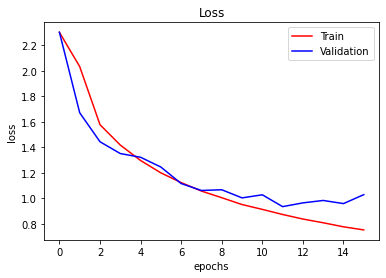

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss00, val_loss00, NAME1 = 'Train', NAME2 = 'Validation')

Train accuracy: 0.6959


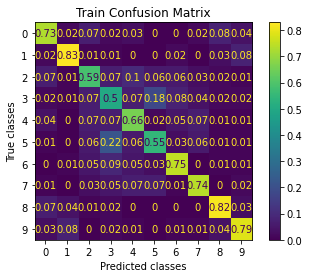

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train accuracy:",metrics.accuracy_score(Y_train_b00.cpu().numpy(), Y_train_pred_b00.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b00.cpu().numpy(), Y_train_pred_b00.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.6866


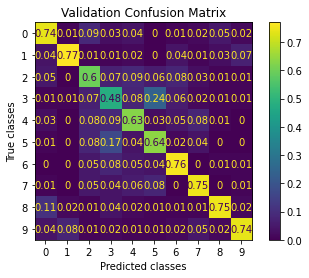

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b00.cpu().numpy(), Y_val_pred_b00.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b00.cpu().numpy(), Y_val_pred_b00.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model00
test_loss00, test_acc00, Y_test00, Y_test_pred00 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:0.920%, Test_Acc:67.960%


Test accuracy: 0.6796


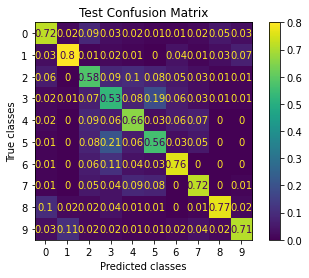

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test00.cpu().numpy(), Y_test_pred00.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test00.cpu().numpy(), Y_test_pred00.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Baseline solo datos etiquetados
train_dataset = x_train10
val_dataset = val_dataset10
##
red0 = models.squeezenet1_0(pretrained = False)
red0.classifier = nn.Sequential( nn.Dropout(p=0.5, inplace=False), 
                                  nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=(1, 1)))
optimizador = optim.SGD(red0.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss01, train_acc01, val_loss01, val_acc01, Y_train_b01, Y_train_pred_b01, Y_val_b01, Y_val_pred_b01, best_model01 = entrenar_red(red0, loss_function, train_dataset, val_dataset, optimizador, epochs, batch_size, reports_every=1, device='cuda', stop = 4)

Epoca:1(10000/10000), Train_Loss:2.292, Train_Acc:13.750%, Validando..., Val_Loss:2.253, Val_Acc:17.640% ,Avg-Time:19.046s.

Epoca:2(10000/10000), Train_Loss:2.203, Train_Acc:19.760%, Validando..., Val_Loss:2.115, Val_Acc:24.460% ,Avg-Time:17.540s.

Epoca:3(10000/10000), Train_Loss:2.012, Train_Acc:25.660%, Validando..., Val_Loss:1.874, Val_Acc:30.600% ,Avg-Time:17.062s.

Epoca:4(10000/10000), Train_Loss:1.866, Train_Acc:30.510%, Validando..., Val_Loss:1.811, Val_Acc:33.460% ,Avg-Time:16.834s.

Epoca:5(10000/10000), Train_Loss:1.802, Train_Acc:32.400%, Validando..., Val_Loss:1.736, Val_Acc:34.900% ,Avg-Time:16.694s.

Epoca:6(10000/10000), Train_Loss:1.731, Train_Acc:34.850%, Validando..., Val_Loss:1.718, Val_Acc:36.960% ,Avg-Time:16.598s.

Epoca:7(10000/10000), Train_Loss:1.707, Train_Acc:36.650%, Validando..., Val_Loss:1.651, Val_Acc:39.280% ,Avg-Time:16.585s.

Epoca:8(10000/10000), Train_Loss:1.657, Train_Acc:38.580%, Validando..., Val_Loss:1.634, Val_Acc:40.440% ,Avg-Time:16.523s.



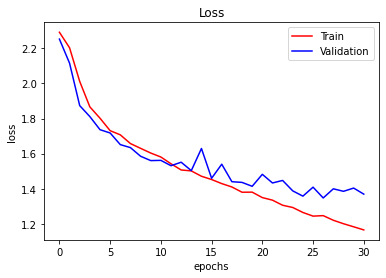

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss01, val_loss01, NAME1 = 'Train', NAME2 = 'Validation')

Train accuracy: 0.5564


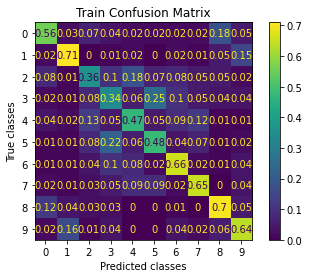

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train accuracy:",metrics.accuracy_score(Y_train_b01.cpu().numpy(), Y_train_pred_b01.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b01.cpu().numpy(), Y_train_pred_b01.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.5312


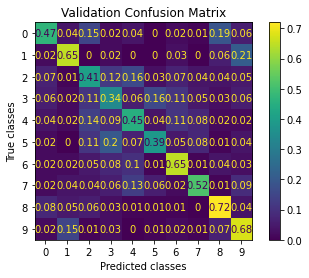

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b01.cpu().numpy(), Y_val_pred_b01.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b01.cpu().numpy(), Y_val_pred_b01.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model01
test_loss01, test_acc01, Y_test01, Y_test_pred01 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.380%, Test_Acc:51.080%


Test accuracy: 0.5108


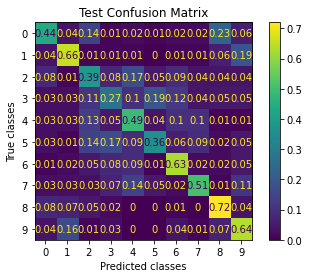

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test01.cpu().numpy(), Y_test_pred01.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test01.cpu().numpy(), Y_test_pred01.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Definición hiperparámetros
lam = 1
B = 32
tau = 0.95
mu = 7

In [ ]:
# Fixmatch strong 1
train_unlab_dataset = aug_data10
train_lab_dataset = x_train10
val_dataset = val_dataset10
##
red0 = models.squeezenet1_0(pretrained = False)
red0.classifier = nn.Sequential( nn.Dropout(p=0.5, inplace=False), 
                                  nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=(1, 1)))
optimizador = optim.SGD(red0.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss02, ls_list02, lu_list02, train_acc02, val_loss02, val_acc02, Y_train_b02, Y_train_pred_b02, Y_val_b02, Y_val_pred_b02, avg_acc_weak02, best_model02 = entrenar_red_fixmatch(red0, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 4)

total_train_lab: 10000 B: 32 batches_lab: 312.5
total_train_unlab: 50000 batch_size_unlab: 224 batches_unlab: 223.21428571428572
Epoca:1(10000/10000), Train_Loss:2.302 ,Train_ls:2.302 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.294, Val_Acc:10.620%, Avg-Time:142.276s.

Epoca:2(10000/10000), Train_Loss:2.285 ,Train_ls:2.285 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.263, Val_Acc:15.260%, Avg-Time:142.339s.

Epoca:3(10000/10000), Train_Loss:2.232 ,Train_ls:2.232 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.179, Val_Acc:18.600%, Avg-Time:142.380s.

Epoca:4(10000/10000), Train_Loss:2.125 ,Train_ls:2.125 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.072, Val_Acc:22.440%, Avg-Time:142.640s.

Epoca:5(10000/10000), Train_Loss:1.934 ,Train_ls:1.934 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.952, Val_Acc:28.780%, Avg-Time:142.673s.

Epoca:6(10000/10000), Train_Loss:1.830 ,Train_ls:1.830 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.736, Val_Acc:36.280%, Avg-Time:142.473s.

Epoca:7(10000/10000), Tra

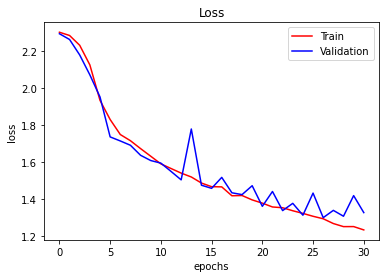

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss02, val_loss02, NAME1 = 'Train', NAME2 = 'Validation')

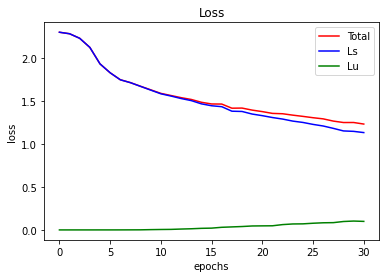

In [ ]:
# Grafico de loss total, loss Ls y loss Lu con respecto a las epocas
plot_fixmatch_loss(train_loss02, ls_list02, lu_list02, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu')

In [ ]:
#Se grafica accuracy solo para datos suavemente aumentados que pasan el umbral
plot_acc_weak(avg_acc_weak02, NAME1 = 'Accuracy')

Train_weak accuracy: 0.9341830822711472


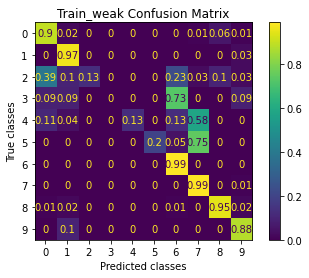

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train_weak accuracy:",metrics.accuracy_score(Y_train_b02.cpu().numpy(), Y_train_pred_b02.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b02.cpu().numpy(), Y_train_pred_b02.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train_weak Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.5552


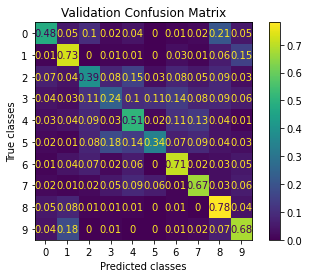

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b02.cpu().numpy(), Y_val_pred_b02.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b02.cpu().numpy(), Y_val_pred_b02.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

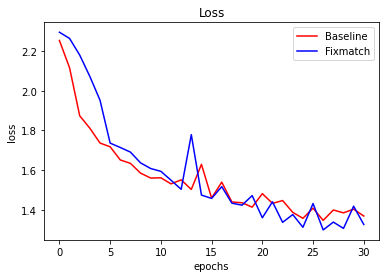

In [ ]:
# Gafico de perdidas baseline y fixmatch
plot_loss(val_loss01, val_loss02, NAME1 = 'Baseline', NAME2 = 'Fixmatch')

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model02
test_loss02, test_acc02, Y_test02, Y_test_pred02 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.351%, Test_Acc:51.940%


Test accuracy: 0.5194


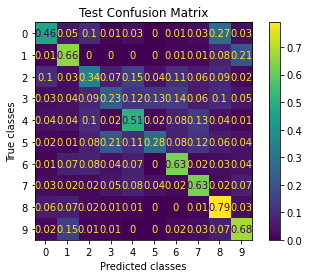

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test02.cpu().numpy(), Y_test_pred02.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test02.cpu().numpy(), Y_test_pred02.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Fixmatch strong 2
train_unlab_dataset = aug_data10_2
train_lab_dataset = x_train10
val_dataset = val_dataset10
##
red0 = models.squeezenet1_0(pretrained = False)
red0.classifier = nn.Sequential( nn.Dropout(p=0.5, inplace=False), 
                                  nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=(1, 1)))
optimizador = optim.SGD(red0.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss03, ls_list03, lu_list03, train_acc03, val_loss03, val_acc03, Y_train_b03, Y_train_pred_b03, Y_val_b03, Y_val_pred_b03, avg_acc_weak03, best_model03 = entrenar_red_fixmatch(red0, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 4)

total_train_lab: 10000 B: 32 batches_lab: 312.5
total_train_unlab: 50000 batch_size_unlab: 224 batches_unlab: 223.21428571428572
Epoca:1(10000/10000), Train_Loss:2.282 ,Train_ls:2.282 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.240, Val_Acc:14.820%, Avg-Time:175.827s.

Epoca:2(10000/10000), Train_Loss:2.194 ,Train_ls:2.194 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.061, Val_Acc:25.800%, Avg-Time:172.814s.

Epoca:3(10000/10000), Train_Loss:2.004 ,Train_ls:2.004 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.852, Val_Acc:27.100%, Avg-Time:171.841s.

Epoca:4(10000/10000), Train_Loss:1.861 ,Train_ls:1.861 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.766, Val_Acc:34.100%, Avg-Time:171.385s.

Epoca:5(10000/10000), Train_Loss:1.792 ,Train_ls:1.792 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.754, Val_Acc:35.600%, Avg-Time:170.952s.

Epoca:6(10000/10000), Train_Loss:1.740 ,Train_ls:1.740 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.688, Val_Acc:35.900%, Avg-Time:170.664s.

Epoca:7(10000/10000), Tra

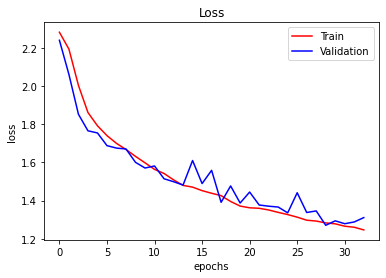

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss03, val_loss03, NAME1 = 'Train', NAME2 = 'Validation')

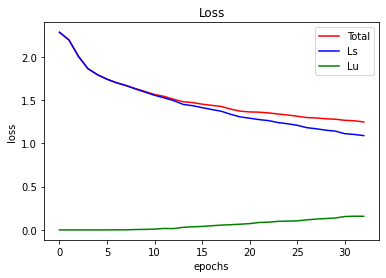

In [ ]:
# Grafico de loss total, loss Ls y loss Lu con respecto a las epocas
plot_fixmatch_loss(train_loss03, ls_list03, lu_list03, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu')

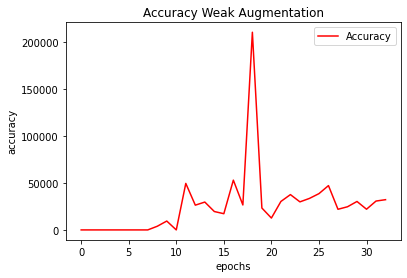

In [ ]:
#Se grafica accuracy solo para datos suavemente aumentados que pasan el umbral
plot_acc_weak(avg_acc_weak03, NAME1 = 'Accuracy')

Train_weak accuracy: 0.9392943618125216


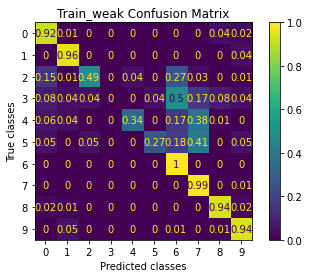

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train_weak accuracy:",metrics.accuracy_score(Y_train_b03.cpu().numpy(), Y_train_pred_b03.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b03.cpu().numpy(), Y_train_pred_b03.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train_weak Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.556


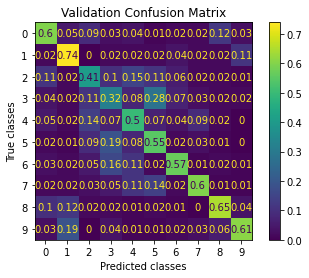

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b03.cpu().numpy(), Y_val_pred_b03.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b03.cpu().numpy(), Y_val_pred_b03.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Gafico de perdidas baseline y fixmatch
#plot_loss(val_loss01, val_loss03, NAME1 = 'Baseline', NAME2 = 'Fixmatch')

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model03
test_loss03, test_acc03, Y_test03, Y_test_pred03 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.313%, Test_Acc:54.300%


Test accuracy: 0.543


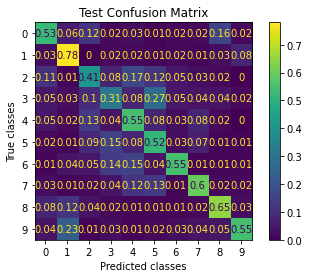

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test03.cpu().numpy(), Y_test_pred03.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test03.cpu().numpy(), Y_test_pred03.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Fixmatch strong 3
train_unlab_dataset = aug_data10_3
train_lab_dataset = x_train10
val_dataset = val_dataset10
##
red0 = models.squeezenet1_0(pretrained = False)
red0.classifier = nn.Sequential( nn.Dropout(p=0.5, inplace=False), 
                                  nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.AdaptiveAvgPool2d(output_size=(1, 1)))
optimizador = optim.SGD(red0.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss04, ls_list04, lu_list04, train_acc04, val_loss04, val_acc04, Y_train_b04, Y_train_pred_b04, Y_val_b04, Y_val_pred_b04, avg_acc_weak04, best_model04  = entrenar_red_fixmatch(red0, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 4)

total_train_lab: 10000 B: 32 batches_lab: 312.5
total_train_unlab: 50000 batch_size_unlab: 224 batches_unlab: 223.21428571428572
Epoca:1(10000/10000), Train_Loss:2.296 ,Train_ls:2.296 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.282, Val_Acc:15.300%, Avg-Time:121.215s.

Epoca:2(10000/10000), Train_Loss:2.234 ,Train_ls:2.234 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.129, Val_Acc:25.240%, Avg-Time:121.694s.

Epoca:3(10000/10000), Train_Loss:2.088 ,Train_ls:2.088 ,Train_lu:0.000 ,, Validando..., Val_Loss:2.006, Val_Acc:27.220%, Avg-Time:121.709s.

Epoca:4(10000/10000), Train_Loss:1.973 ,Train_ls:1.973 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.879, Val_Acc:31.260%, Avg-Time:123.194s.

Epoca:5(10000/10000), Train_Loss:1.898 ,Train_ls:1.897 ,Train_lu:0.001 ,, Validando..., Val_Loss:1.729, Val_Acc:35.420%, Avg-Time:123.026s.

Epoca:6(10000/10000), Train_Loss:1.796 ,Train_ls:1.796 ,Train_lu:0.000 ,, Validando..., Val_Loss:1.775, Val_Acc:33.980%, Avg-Time:122.868s.

Epoca:7(10000/10000), Tra

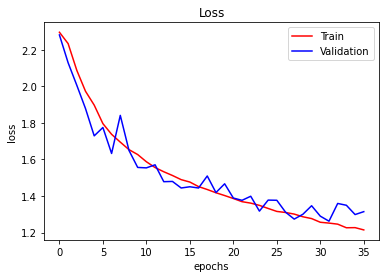

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss04, val_loss04, NAME1 = 'Train', NAME2 = 'Validation')

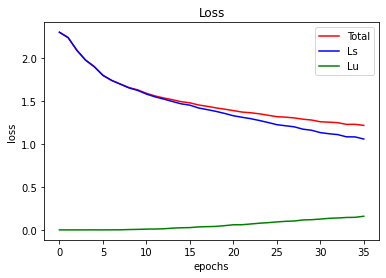

In [ ]:
# Grafico de loss total, loss Ls y loss Lu con respecto a las epocas
plot_fixmatch_loss(train_loss04, ls_list04, lu_list04, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu')

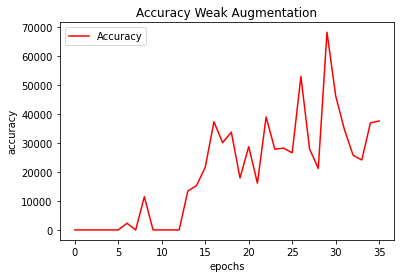

In [ ]:
#Se grafica accuracy solo para datos suavemente aumentados que pasan el umbral
plot_acc_weak(avg_acc_weak04, NAME1 = 'Accuracy')

Train_weak accuracy: 0.9331990600872776


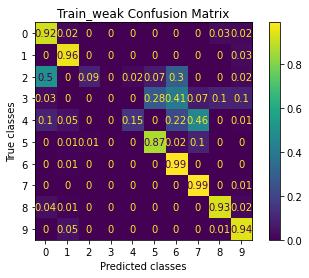

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train_weak accuracy:",metrics.accuracy_score(Y_train_b04.cpu().numpy(), Y_train_pred_b04.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b04.cpu().numpy(), Y_train_pred_b04.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train_weak Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.5614


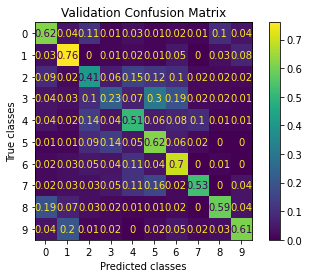

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b04.cpu().numpy(), Y_val_pred_b04.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b04.cpu().numpy(), Y_val_pred_b04.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Gafico de perdidas baseline y fixmatch
#plot_loss(val_loss01, val_loss04, NAME1 = 'Baseline', NAME2 = 'Fixmatch')

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model04
test_loss04, test_acc04, Y_test04, Y_test_pred04 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.270%, Test_Acc:55.040%


Test accuracy: 0.5504


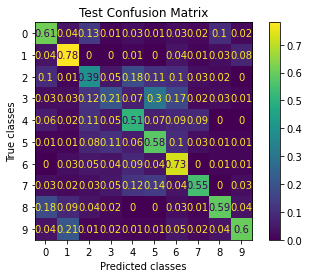

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test04.cpu().numpy(), Y_test_pred04.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test04.cpu().numpy(), Y_test_pred04.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

**Modelo 2**

Corresponde a un InceptionModule de GoogLeNet pero con ciertas modificaciones propias

In [ ]:
class ModifyInceptionModule(nn.Module):
  def __init__(self, num_classes,
               in_channels = 3,
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(ModifyInceptionModule, self).__init__()
    # Capa convolucional 1x1 C1
    self.conv_1p1_3p3_reduce = nn.Conv2d(in_channels, ch_3x3_reduce, (1,1), stride=1, padding=0)
    # Capa convolucional 3x3 D1
    self.conv_3p3 = nn.Conv2d(ch_3x3_reduce, ch_3x3, (3,3), stride=1, padding=1)

    # Capa convolucional 1x1 C2
    self.conv_1p1_5p5_reduce = nn.Conv2d(in_channels, ch_5x5_reduce, (1,1), stride=1, padding=0)
    # Capa convolucional 3x3 D2
    self.conv_5p5 = nn.Conv2d(ch_5x5_reduce, ch_5x5, (5,5), stride=1, padding=2)

    # Capa Max Pooling
    self.pool1 = nn.MaxPool2d((3,3), stride=1, padding=1)
    # Capa convolucional 1x1 D3
    self.conv_1p1_pool = nn.Conv2d(in_channels, ch_pool_proj, (1,1), stride=1, padding=0)

    # Capa convolucional 1x1 D4
    #self.conv_1p1 = nn.Conv2d(in_channels, ch_1x1, (1,1), stride=1, padding=0)

    # Capa convolucional 1x1 para reducir canales
    in_channels_cat = ch_3x3 + ch_5x5
    self.conv_1p1 = nn.Conv2d(in_channels_cat, 60, (1,1), stride=1, padding=0)
    # Batch Normalization
    self.bn1 = nn.BatchNorm2d(60)
    # Dropout
    self.dropout1 = nn.Dropout2d(0.3) 
    # Pool para reducir a 16x16
    self.pool2 = nn.MaxPool2d((2,2), stride=2)
    # Dos capas fully connected
    self.fc1 = nn.Linear(60 * 16 * 16, 200)
    self.bn2 = nn.BatchNorm1d(200)
    self.dropout2 = nn.Dropout(0.2)
    self.fc_out = nn.Linear(200,num_classes)

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 

    # Se calcula capa C1, C2 y Max Pooling en paralelo
    C1 = self.conv_1p1_3p3_reduce(x)
    C2 = self.conv_1p1_5p5_reduce(x)

    # Se calcula capa D1, D2, D3 y D4 en paralelo
    D1 = self.conv_3p3(C1)
    D2 = self.conv_5p5(C2)

    # Se concatenan las salidas obtenidas
    x = torch.cat([D1,D2], dim=1)


    x = F.relu(self.conv_1p1(x))
    x = self.dropout1(self.bn1(x))
    x = self.pool2(x) 
    x = x.view(-1, 60 * 16 * 16)
    x = F.relu(self.fc1(x))
    x = self.dropout2(self.bn2(x))
      
    # La salida es simplemente la aplicación de la última capa.
    y_pred = self.fc_out(x)

    return y_pred

In [ ]:
# Definición hiperparámetros
batch_size = 64
epochs = 300
loss_function = torch.nn.CrossEntropyLoss()
etha, beta, decay = 0.003, 0.9, 0.0005
num_classes = 10

In [ ]:
# Baseline solo datos etiquetados
train_dataset = x_train10
val_dataset = val_dataset10
##
red1 = ModifyInceptionModule(10)
optimizador = optim.SGD(red1.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss11, train_acc11, val_loss11, val_acc11, Y_train_b11, Y_train_pred_b11, Y_val_b11, Y_val_pred_b11, best_model11 = entrenar_red(red1, loss_function, train_dataset, val_dataset, optimizador, epochs, batch_size, reports_every=1, device='cuda', stop = 7)

Epoca:1(10000/10000), Train_Loss:1.900, Train_Acc:32.270%, Validando..., Val_Loss:1.637, Val_Acc:41.880% ,Avg-Time:16.062s.

Epoca:2(10000/10000), Train_Loss:1.622, Train_Acc:42.030%, Validando..., Val_Loss:1.490, Val_Acc:47.460% ,Avg-Time:15.048s.

Epoca:3(10000/10000), Train_Loss:1.523, Train_Acc:45.040%, Validando..., Val_Loss:1.422, Val_Acc:48.880% ,Avg-Time:14.500s.

Epoca:4(10000/10000), Train_Loss:1.439, Train_Acc:48.000%, Validando..., Val_Loss:1.366, Val_Acc:51.820% ,Avg-Time:14.311s.

Epoca:5(10000/10000), Train_Loss:1.362, Train_Acc:51.540%, Validando..., Val_Loss:1.341, Val_Acc:52.180% ,Avg-Time:14.057s.

Epoca:6(10000/10000), Train_Loss:1.309, Train_Acc:53.420%, Validando..., Val_Loss:1.304, Val_Acc:53.740% ,Avg-Time:13.938s.

Epoca:7(10000/10000), Train_Loss:1.245, Train_Acc:55.900%, Validando..., Val_Loss:1.257, Val_Acc:55.240% ,Avg-Time:13.826s.

Epoca:8(10000/10000), Train_Loss:1.196, Train_Acc:57.590%, Validando..., Val_Loss:1.274, Val_Acc:54.820% ,Avg-Time:13.808s.



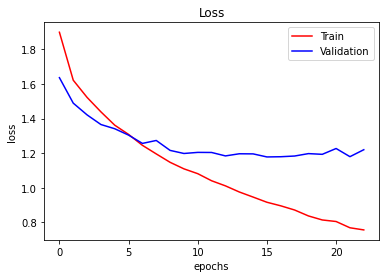

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss11, val_loss11, NAME1 = 'Train', NAME2 = 'Validation')

Train accuracy: 0.6773


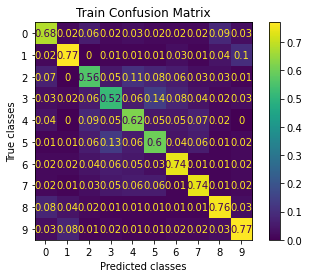

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train accuracy:",metrics.accuracy_score(Y_train_b11.cpu().numpy(), Y_train_pred_b11.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b11.cpu().numpy(), Y_train_pred_b11.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.599


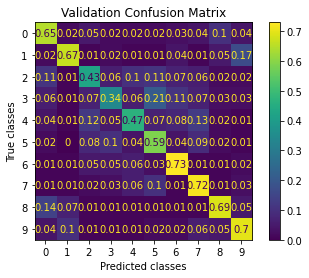

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b11.cpu().numpy(), Y_val_pred_b11.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b11.cpu().numpy(), Y_val_pred_b11.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model11
test_loss11, test_acc11, Y_test11, Y_test_pred11 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.198%, Test_Acc:59.080%


Test accuracy: 0.5908


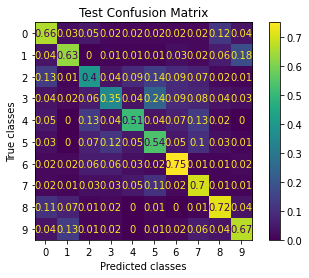

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test11.cpu().numpy(), Y_test_pred11.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test11.cpu().numpy(), Y_test_pred11.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Definición hiperparámetros
lam = 1
B = 64
tau = 0.95
mu = 7

In [ ]:
# Fixmatch strong 3
train_unlab_dataset = aug_data10_3
train_lab_dataset = x_train10
val_dataset = val_dataset10
##
red1 = ModifyInceptionModule(10)
optimizador = optim.SGD(red1.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss12, ls_list12, lu_list12, train_acc12, val_loss12, val_acc12, Y_train_b12, Y_train_pred_b12, Y_val_b12, Y_val_pred_b12, avg_acc_weak12, best_model12 = entrenar_red_fixmatch(red1, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 7)

total_train_lab: 10000 B: 64 batches_lab: 156.25
total_train_unlab: 50000 batch_size_unlab: 448 batches_unlab: 111.60714285714286
Epoca:1(10000/10000), Train_Loss:1.882 ,Train_ls:1.880 ,Train_lu:0.002 ,, Validando..., Val_Loss:1.725, Val_Acc:39.060%, Avg-Time:134.715s.

Epoca:2(10000/10000), Train_Loss:1.643 ,Train_ls:1.633 ,Train_lu:0.010 ,, Validando..., Val_Loss:1.491, Val_Acc:46.680%, Avg-Time:154.108s.

Epoca:3(10000/10000), Train_Loss:1.547 ,Train_ls:1.532 ,Train_lu:0.015 ,, Validando..., Val_Loss:1.459, Val_Acc:47.480%, Avg-Time:160.347s.

Epoca:4(10000/10000), Train_Loss:1.481 ,Train_ls:1.458 ,Train_lu:0.023 ,, Validando..., Val_Loss:1.404, Val_Acc:49.600%, Avg-Time:163.583s.

Epoca:5(10000/10000), Train_Loss:1.433 ,Train_ls:1.399 ,Train_lu:0.034 ,, Validando..., Val_Loss:1.343, Val_Acc:51.860%, Avg-Time:165.490s.

Epoca:6(10000/10000), Train_Loss:1.379 ,Train_ls:1.336 ,Train_lu:0.043 ,, Validando..., Val_Loss:1.336, Val_Acc:51.080%, Avg-Time:166.862s.

Epoca:7(10000/10000), Tr

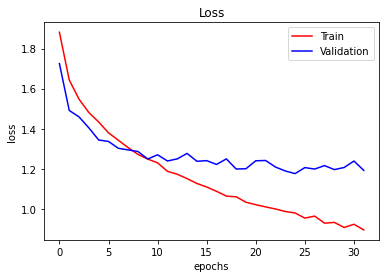

In [ ]:
# Grafico de loss de entrenamiento y de validación con respecto a las epocas
plot_loss(train_loss12, val_loss12, NAME1 = 'Train', NAME2 = 'Validation')

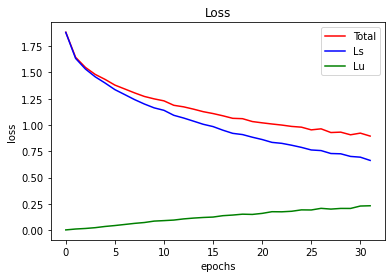

In [ ]:
# Grafico de loss total, loss Ls y loss Lu con respecto a las epocas
plot_fixmatch_loss(train_loss12, ls_list12, lu_list12, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu')

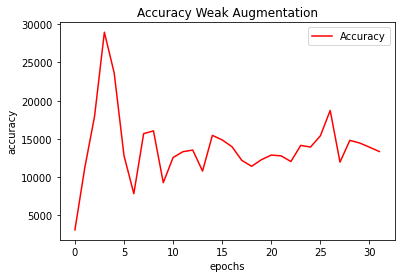

In [ ]:
#Se grafica accuracy solo para datos suavemente aumentados que pasan el umbral
plot_acc_weak(avg_acc_weak12, NAME1 = 'Accuracy')

Train_weak accuracy: 0.9210436367779423


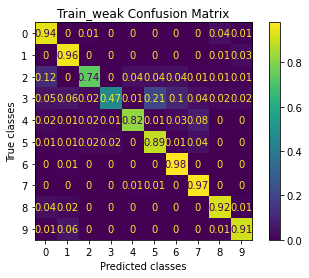

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train_weak accuracy:",metrics.accuracy_score(Y_train_b12.cpu().numpy(), Y_train_pred_b12.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b12.cpu().numpy(), Y_train_pred_b12.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Train_weak Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.6078


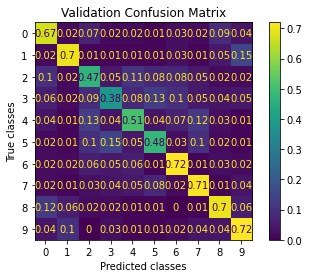

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b12.cpu().numpy(), Y_val_pred_b12.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b12.cpu().numpy(), Y_val_pred_b12.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

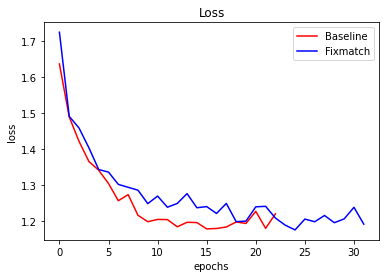

In [ ]:
# Gafico de perdidas baseline y fixmatch
plot_loss(val_loss11, val_loss12, NAME1 = 'Baseline', NAME2 = 'Fixmatch')

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset10
best_red = best_model12
test_loss12, test_acc12, Y_test12, Y_test_pred12 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:1.210%, Test_Acc:59.520%


Test accuracy: 0.5952


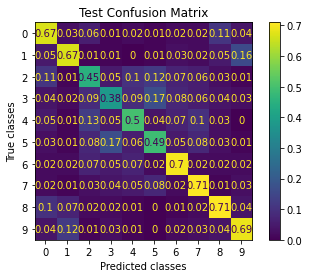

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test12.cpu().numpy(), Y_test_pred12.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test12.cpu().numpy(), Y_test_pred12.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round, display_labels = [0,1,2,3,4,5,6,7,8,9])
disp.plot()
disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

**Pruebas con "CIFAR-100"**

In [ ]:
# Definición hiperparámetros
batch_size = 64
epochs = 300
loss_function = torch.nn.CrossEntropyLoss()
etha, beta, decay = 0.003, 0.9, 0.0005
num_classes = 10

In [ ]:
# Baseline solo datos etiquetados
train_dataset = x_train100
val_dataset = val_dataset100
##
##
red2 = ModifyInceptionModule(100)
optimizador = optim.SGD(red2.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss21, train_acc21, val_loss21, val_acc21, Y_train_b21, Y_train_pred_b21, Y_val_b21, Y_val_pred_b21, best_model21 = entrenar_red(red2, loss_function, train_dataset, val_dataset, optimizador, epochs, batch_size, reports_every=1, device='cuda', stop = 7)

Epoca:1(10000/10000), Train_Loss:4.353, Train_Acc:5.320%, Validando..., Val_Loss:4.068, Val_Acc:9.680% ,Avg-Time:14.430s.

Epoca:2(10000/10000), Train_Loss:3.990, Train_Acc:10.620%, Validando..., Val_Loss:3.839, Val_Acc:13.760% ,Avg-Time:14.360s.

Epoca:3(10000/10000), Train_Loss:3.760, Train_Acc:14.480%, Validando..., Val_Loss:3.675, Val_Acc:16.300% ,Avg-Time:14.394s.

Epoca:4(10000/10000), Train_Loss:3.592, Train_Acc:16.790%, Validando..., Val_Loss:3.561, Val_Acc:18.400% ,Avg-Time:14.351s.

Epoca:5(10000/10000), Train_Loss:3.442, Train_Acc:20.000%, Validando..., Val_Loss:3.525, Val_Acc:18.740% ,Avg-Time:14.440s.

Epoca:6(10000/10000), Train_Loss:3.350, Train_Acc:21.150%, Validando..., Val_Loss:3.516, Val_Acc:18.800% ,Avg-Time:14.400s.

Epoca:7(10000/10000), Train_Loss:3.269, Train_Acc:23.020%, Validando..., Val_Loss:3.385, Val_Acc:21.480% ,Avg-Time:14.399s.

Epoca:8(10000/10000), Train_Loss:3.158, Train_Acc:25.480%, Validando..., Val_Loss:3.599, Val_Acc:18.180% ,Avg-Time:14.372s.

Ep

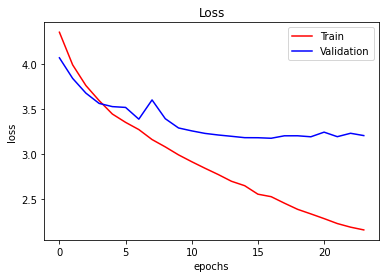

In [ ]:
plot_loss(train_loss21, val_loss21, NAME1 = 'Train', NAME2 = 'Validation')

Train accuracy: 0.3783


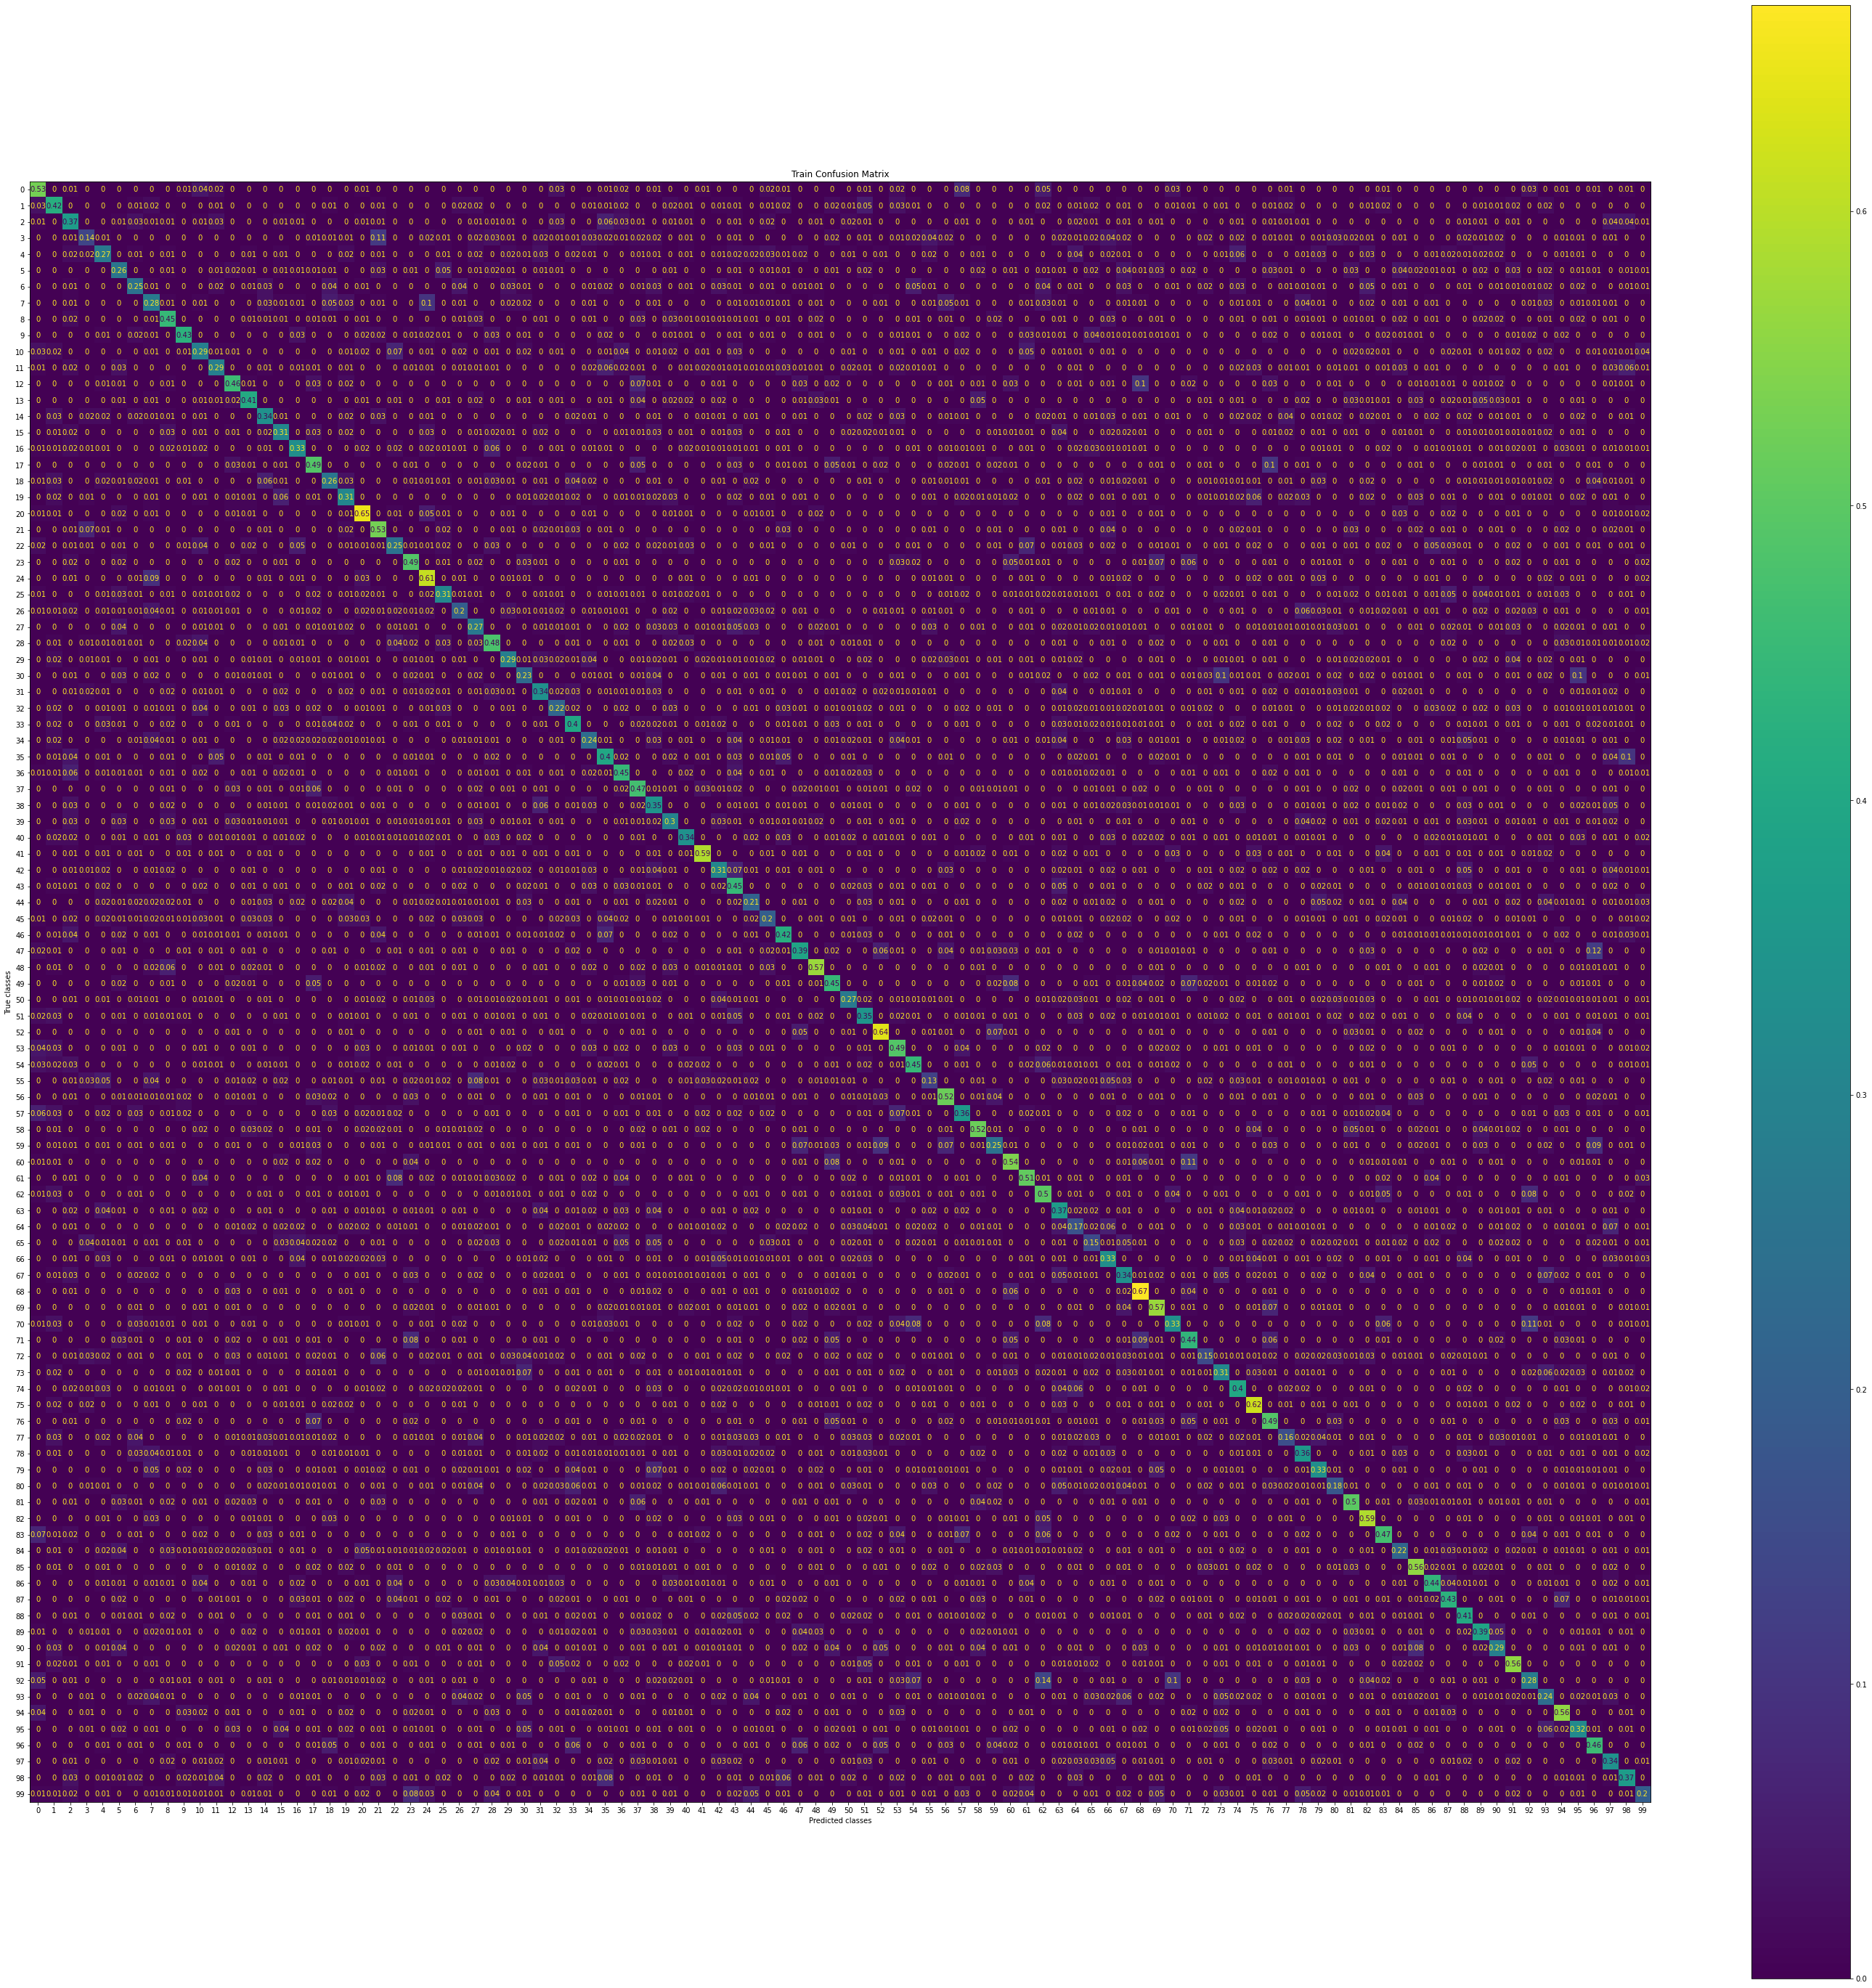

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train accuracy:",metrics.accuracy_score(Y_train_b21.cpu().numpy(), Y_train_pred_b21.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b21.cpu().numpy(), Y_train_pred_b21.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Train Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.2406


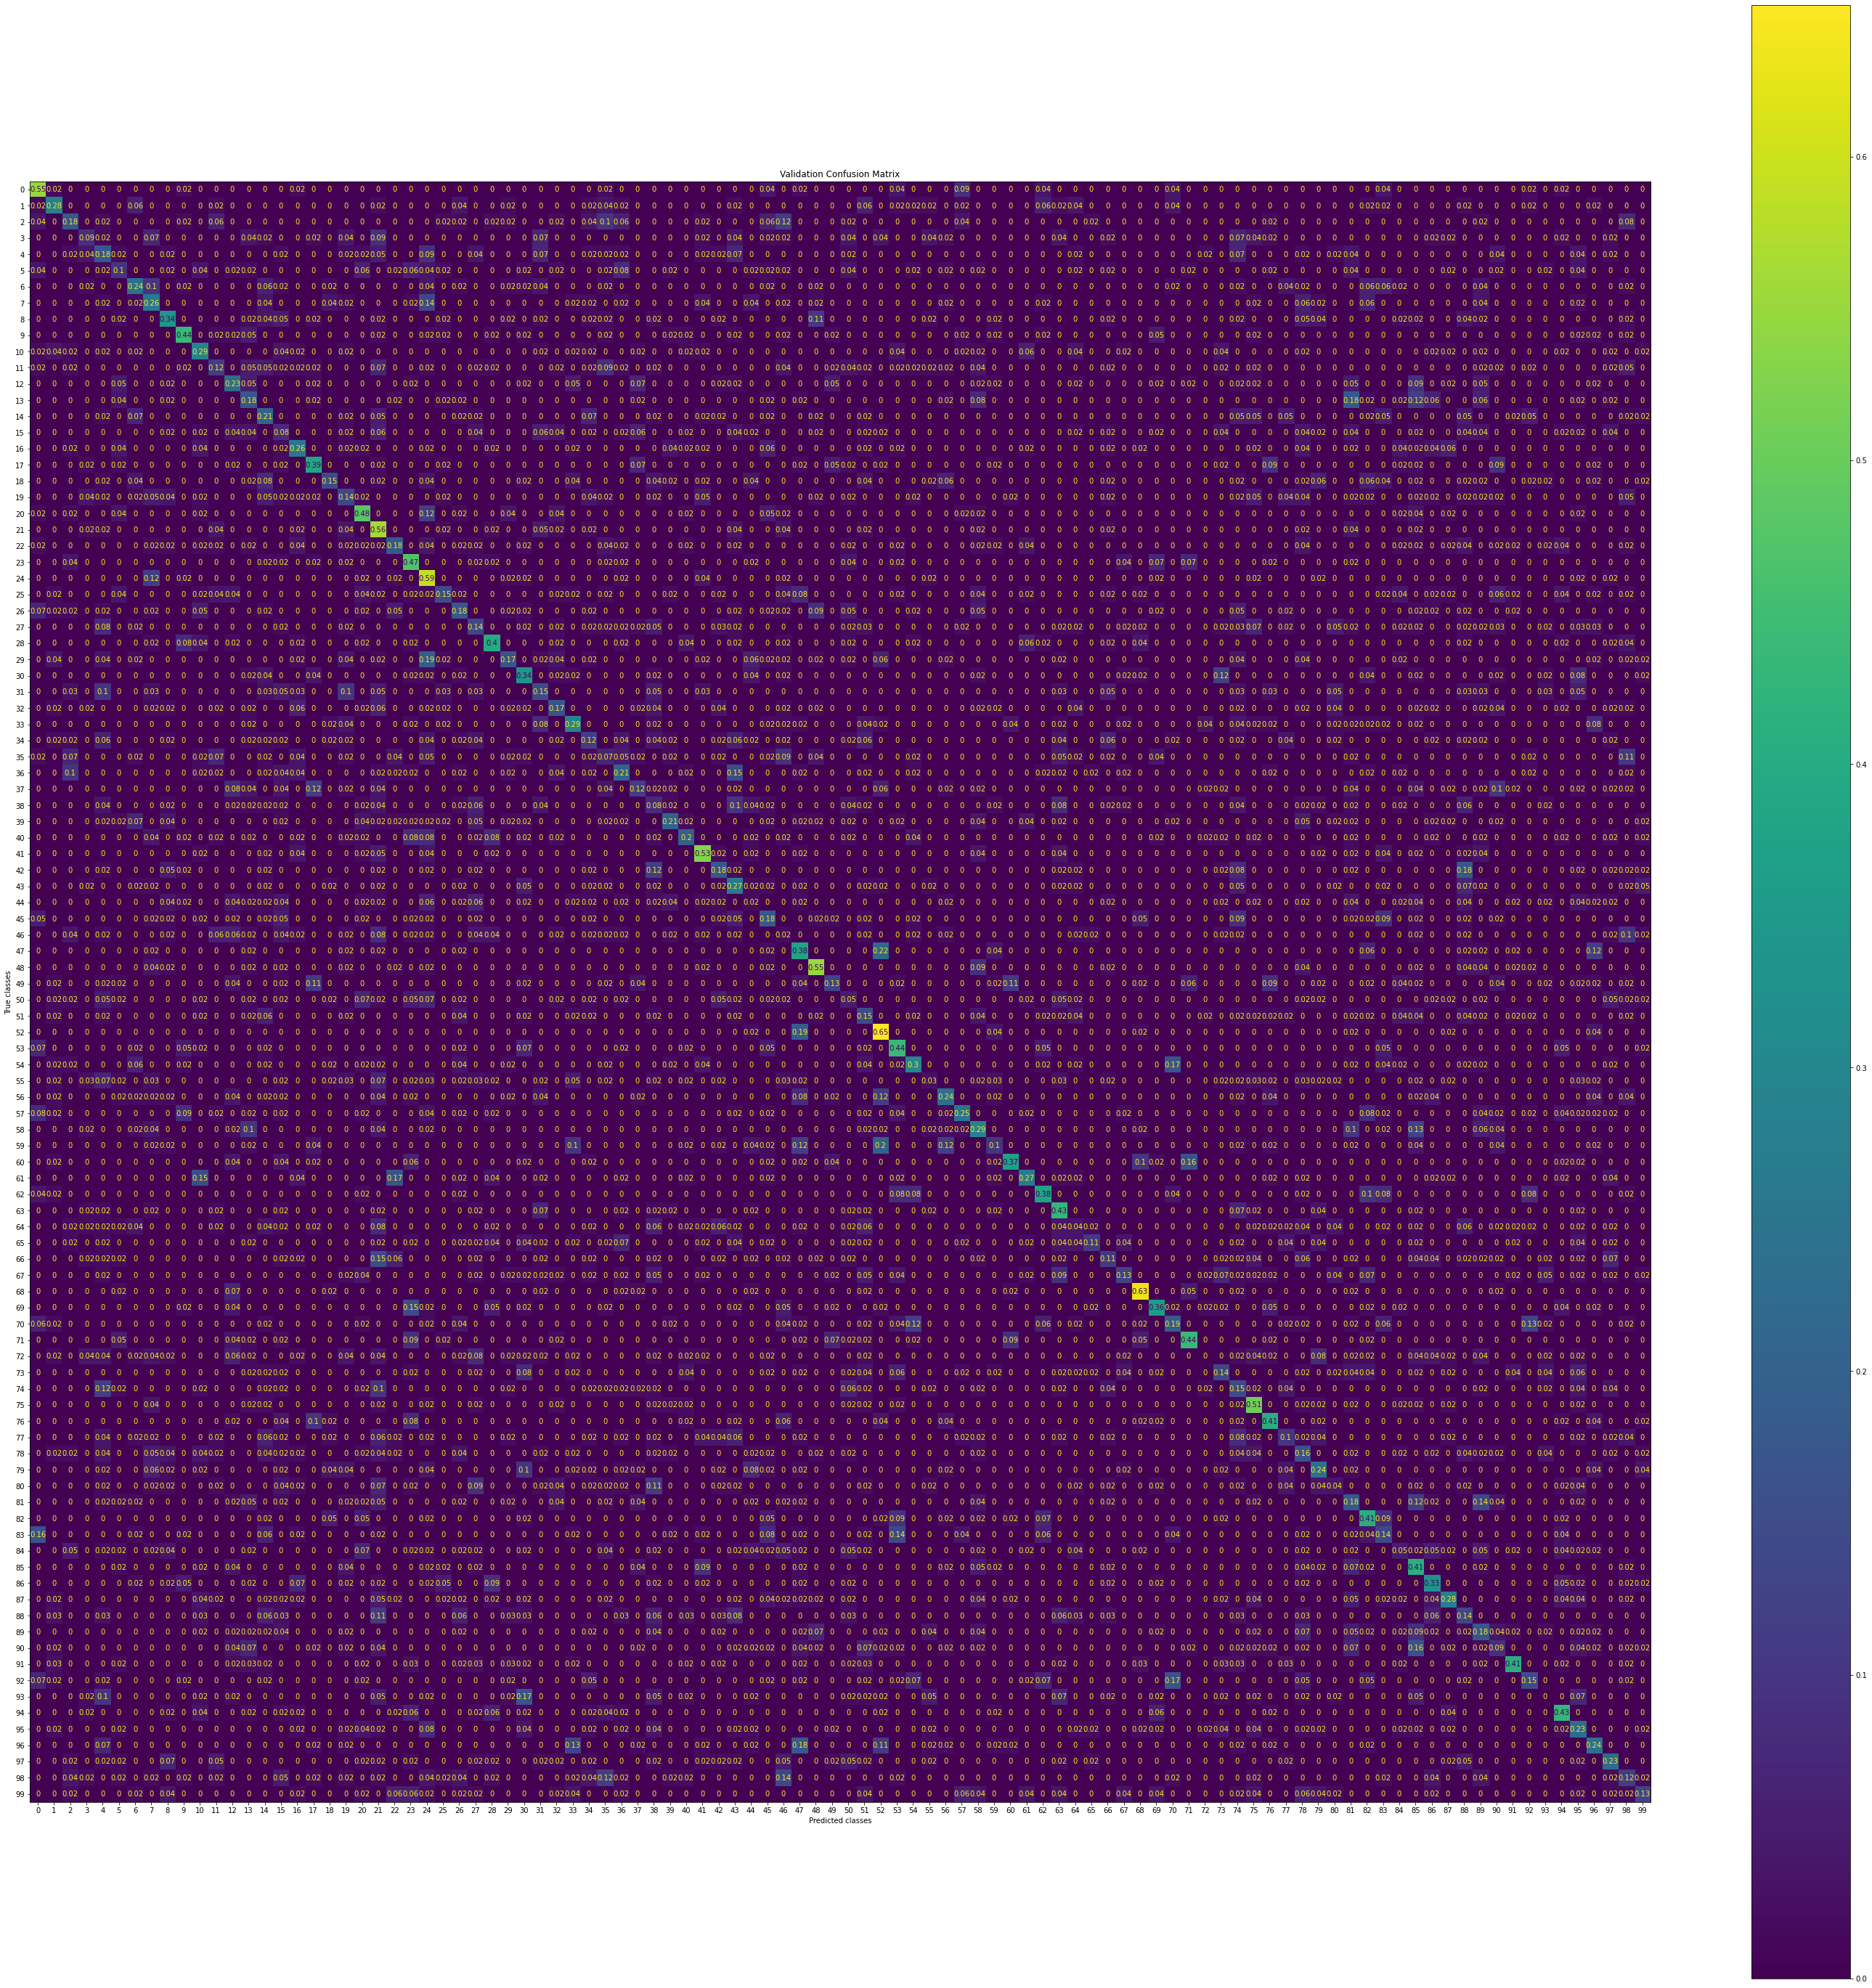

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b21.cpu().numpy(), Y_val_pred_b21.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b21.cpu().numpy(), Y_val_pred_b21.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset100
best_red = best_model21
test_loss21, test_acc21, Y_test21, Y_test_pred21 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:3.164%, Test_Acc:24.920%


Test accuracy: 0.2492


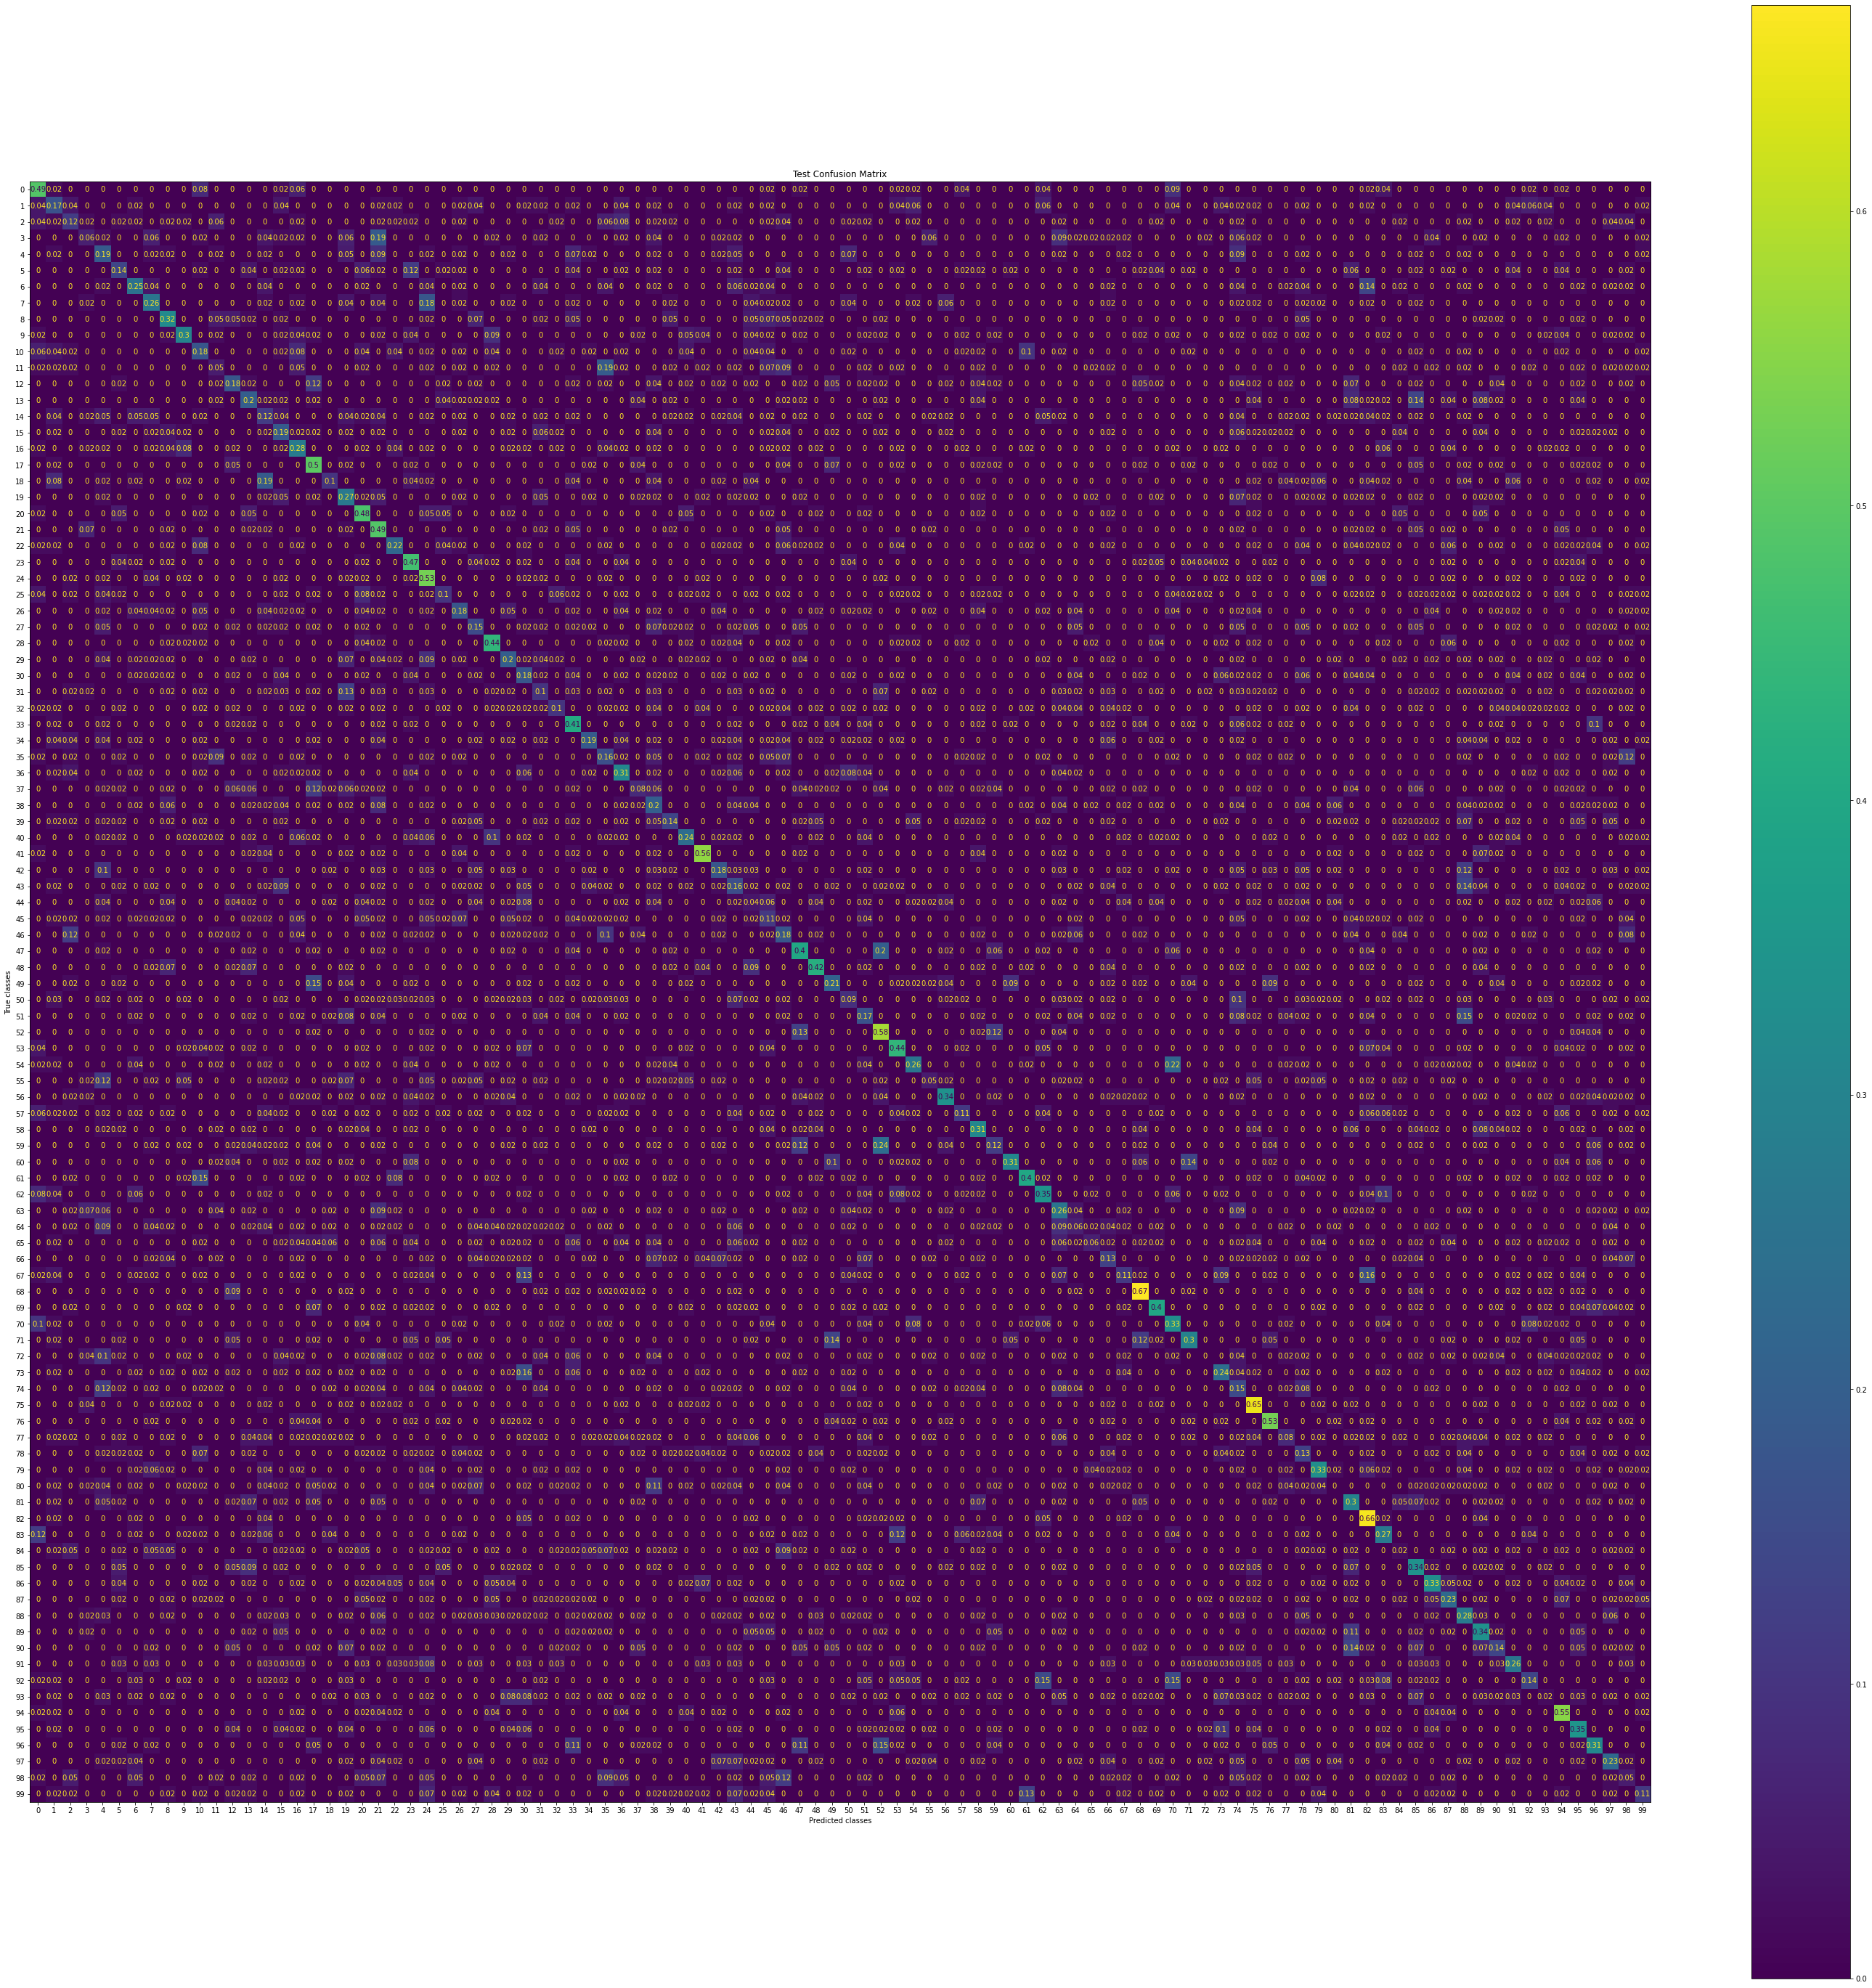

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test21.cpu().numpy(), Y_test_pred21.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test21.cpu().numpy(), Y_test_pred21.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

In [ ]:
# Definición hiperparámetros
lam = 1
B = 64
tau = 0.95
mu = 7

In [ ]:
# Fixmatch strong 3
train_unlab_dataset = aug_data100_3
train_lab_dataset = x_train100
val_dataset = val_dataset100
##
red2 = ModifyInceptionModule(100)
optimizador = optim.SGD(red2.parameters(), lr = etha, momentum = beta, weight_decay = decay, nesterov = True)
train_loss22, ls_list22, lu_list22, train_acc22, val_loss22, val_acc22, Y_train_b22, Y_train_pred_b22, Y_val_b22, Y_val_pred_b22, avg_acc_weak22, best_model22 = entrenar_red_fixmatch(red2, loss_function, train_lab_dataset, val_dataset, train_unlab_dataset, optimizador, epochs, lam,  B, tau, mu, reports_every = 1, device = 'cuda', stop = 7)

total_train_lab: 10000 B: 64 batches_lab: 156.25
total_train_unlab: 50000 batch_size_unlab: 448 batches_unlab: 111.60714285714286
Epoca:1(10000/10000), Train_Loss:4.376 ,Train_ls:4.376 ,Train_lu:0.000 ,, Validando..., Val_Loss:4.056, Val_Acc:9.720%, Avg-Time:167.949s.

Epoca:2(10000/10000), Train_Loss:4.007 ,Train_ls:4.006 ,Train_lu:0.000 ,, Validando..., Val_Loss:3.864, Val_Acc:13.260%, Avg-Time:185.876s.

Epoca:3(10000/10000), Train_Loss:3.785 ,Train_ls:3.785 ,Train_lu:0.000 ,, Validando..., Val_Loss:3.709, Val_Acc:14.900%, Avg-Time:191.255s.

Epoca:4(10000/10000), Train_Loss:3.624 ,Train_ls:3.623 ,Train_lu:0.000 ,, Validando..., Val_Loss:3.611, Val_Acc:17.220%, Avg-Time:193.907s.

Epoca:5(10000/10000), Train_Loss:3.495 ,Train_ls:3.494 ,Train_lu:0.001 ,, Validando..., Val_Loss:3.530, Val_Acc:18.740%, Avg-Time:195.486s.

Epoca:6(10000/10000), Train_Loss:3.369 ,Train_ls:3.369 ,Train_lu:0.001 ,, Validando..., Val_Loss:3.454, Val_Acc:20.100%, Avg-Time:196.489s.

Epoca:7(10000/10000), Tra

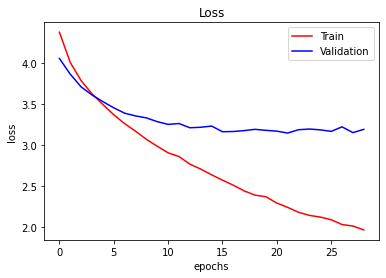

In [ ]:
plot_loss(train_loss22, val_loss22, NAME1 = 'Train', NAME2 = 'Validation')

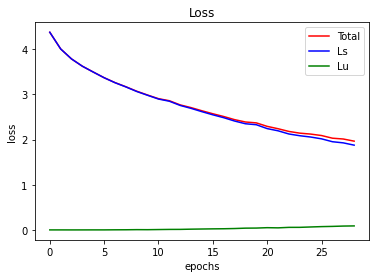

In [ ]:
plot_fixmatch_loss(train_loss22, ls_list22, lu_list22, NAME1 = 'Total', NAME2 = 'Ls', NAME3 = 'Lu')

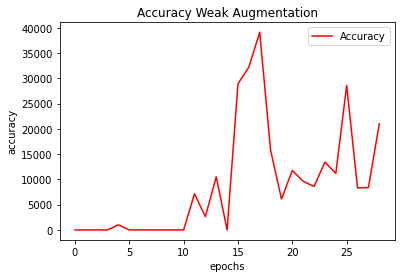

In [ ]:
#Se grafica accuracy solo para datos suavemente aumentados que pasan el umbral
plot_acc_weak(avg_acc_weak22, NAME1 = 'Accuracy')

Train_weak accuracy: 0.9001560062402496


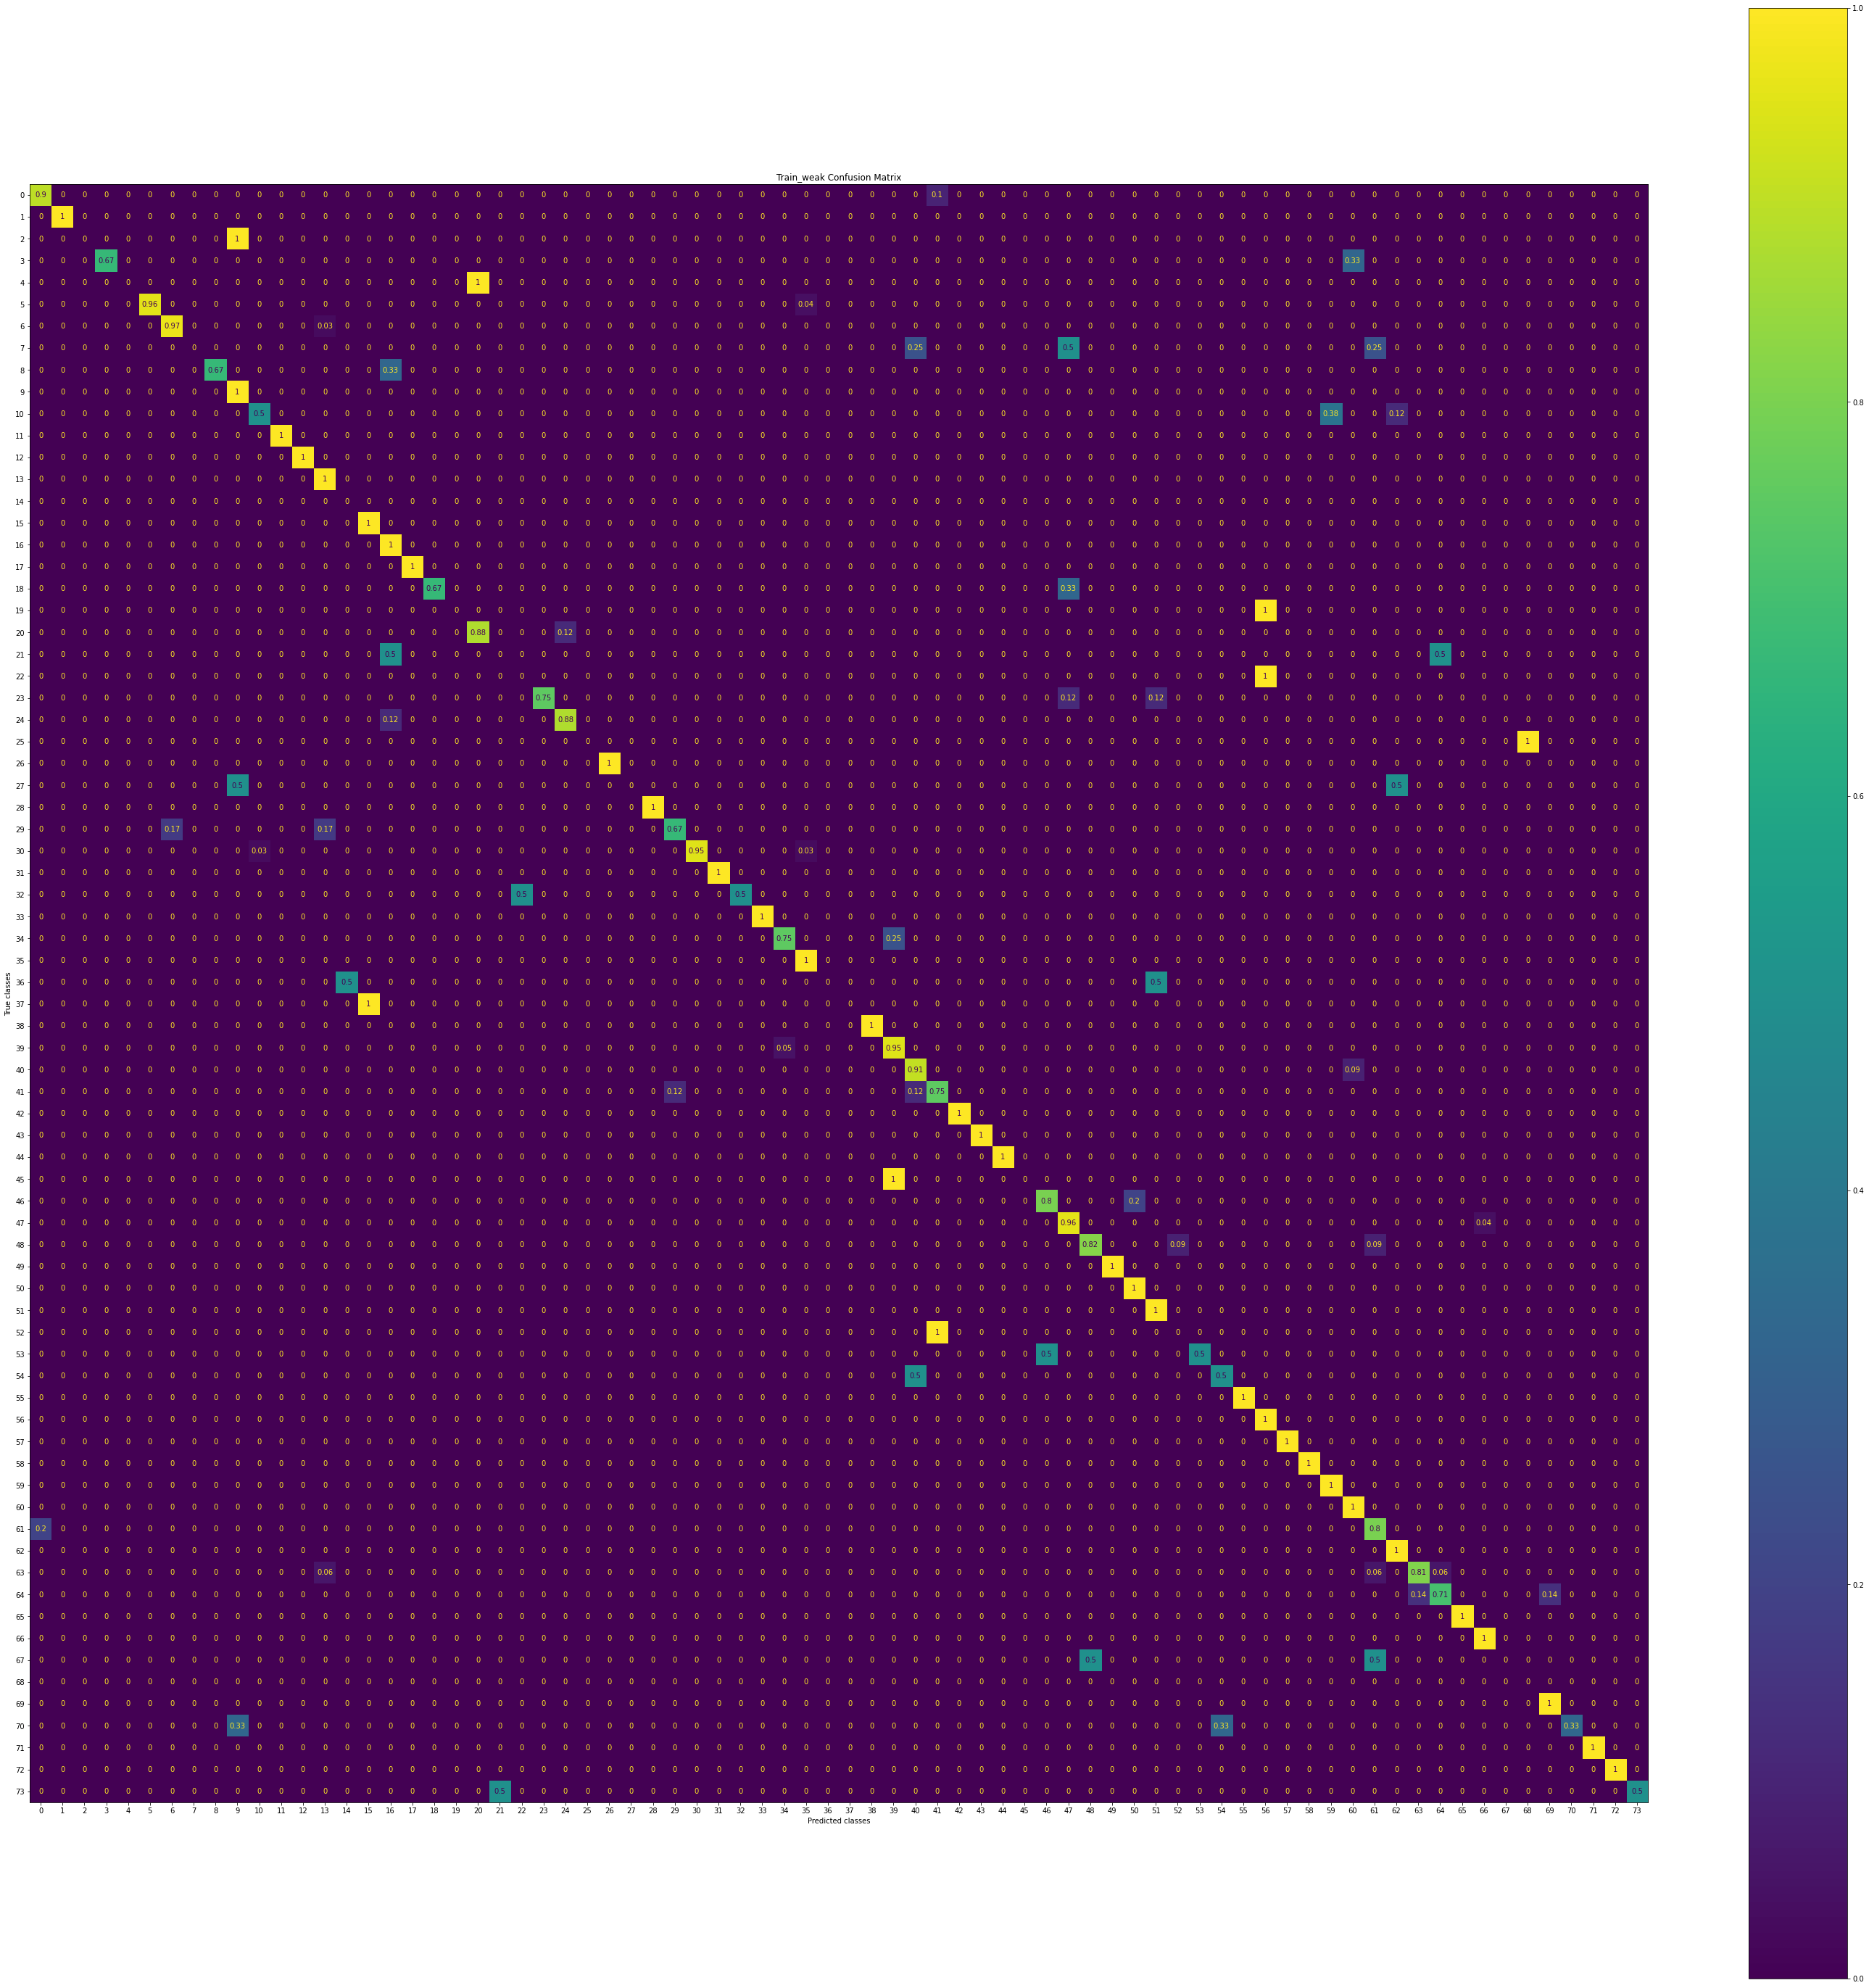

In [ ]:
# Matriz de confusión solo de los datos debilmente aumentados que pasan el umbral
#matriz confusion weak
from sklearn import metrics
# Se imprime accuracy
print("Train_weak accuracy:",metrics.accuracy_score(Y_train_b22.cpu().numpy(), Y_train_pred_b22.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_train_b22.cpu().numpy(), Y_train_pred_b22.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Train_weak Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

Validation accuracy: 0.2474


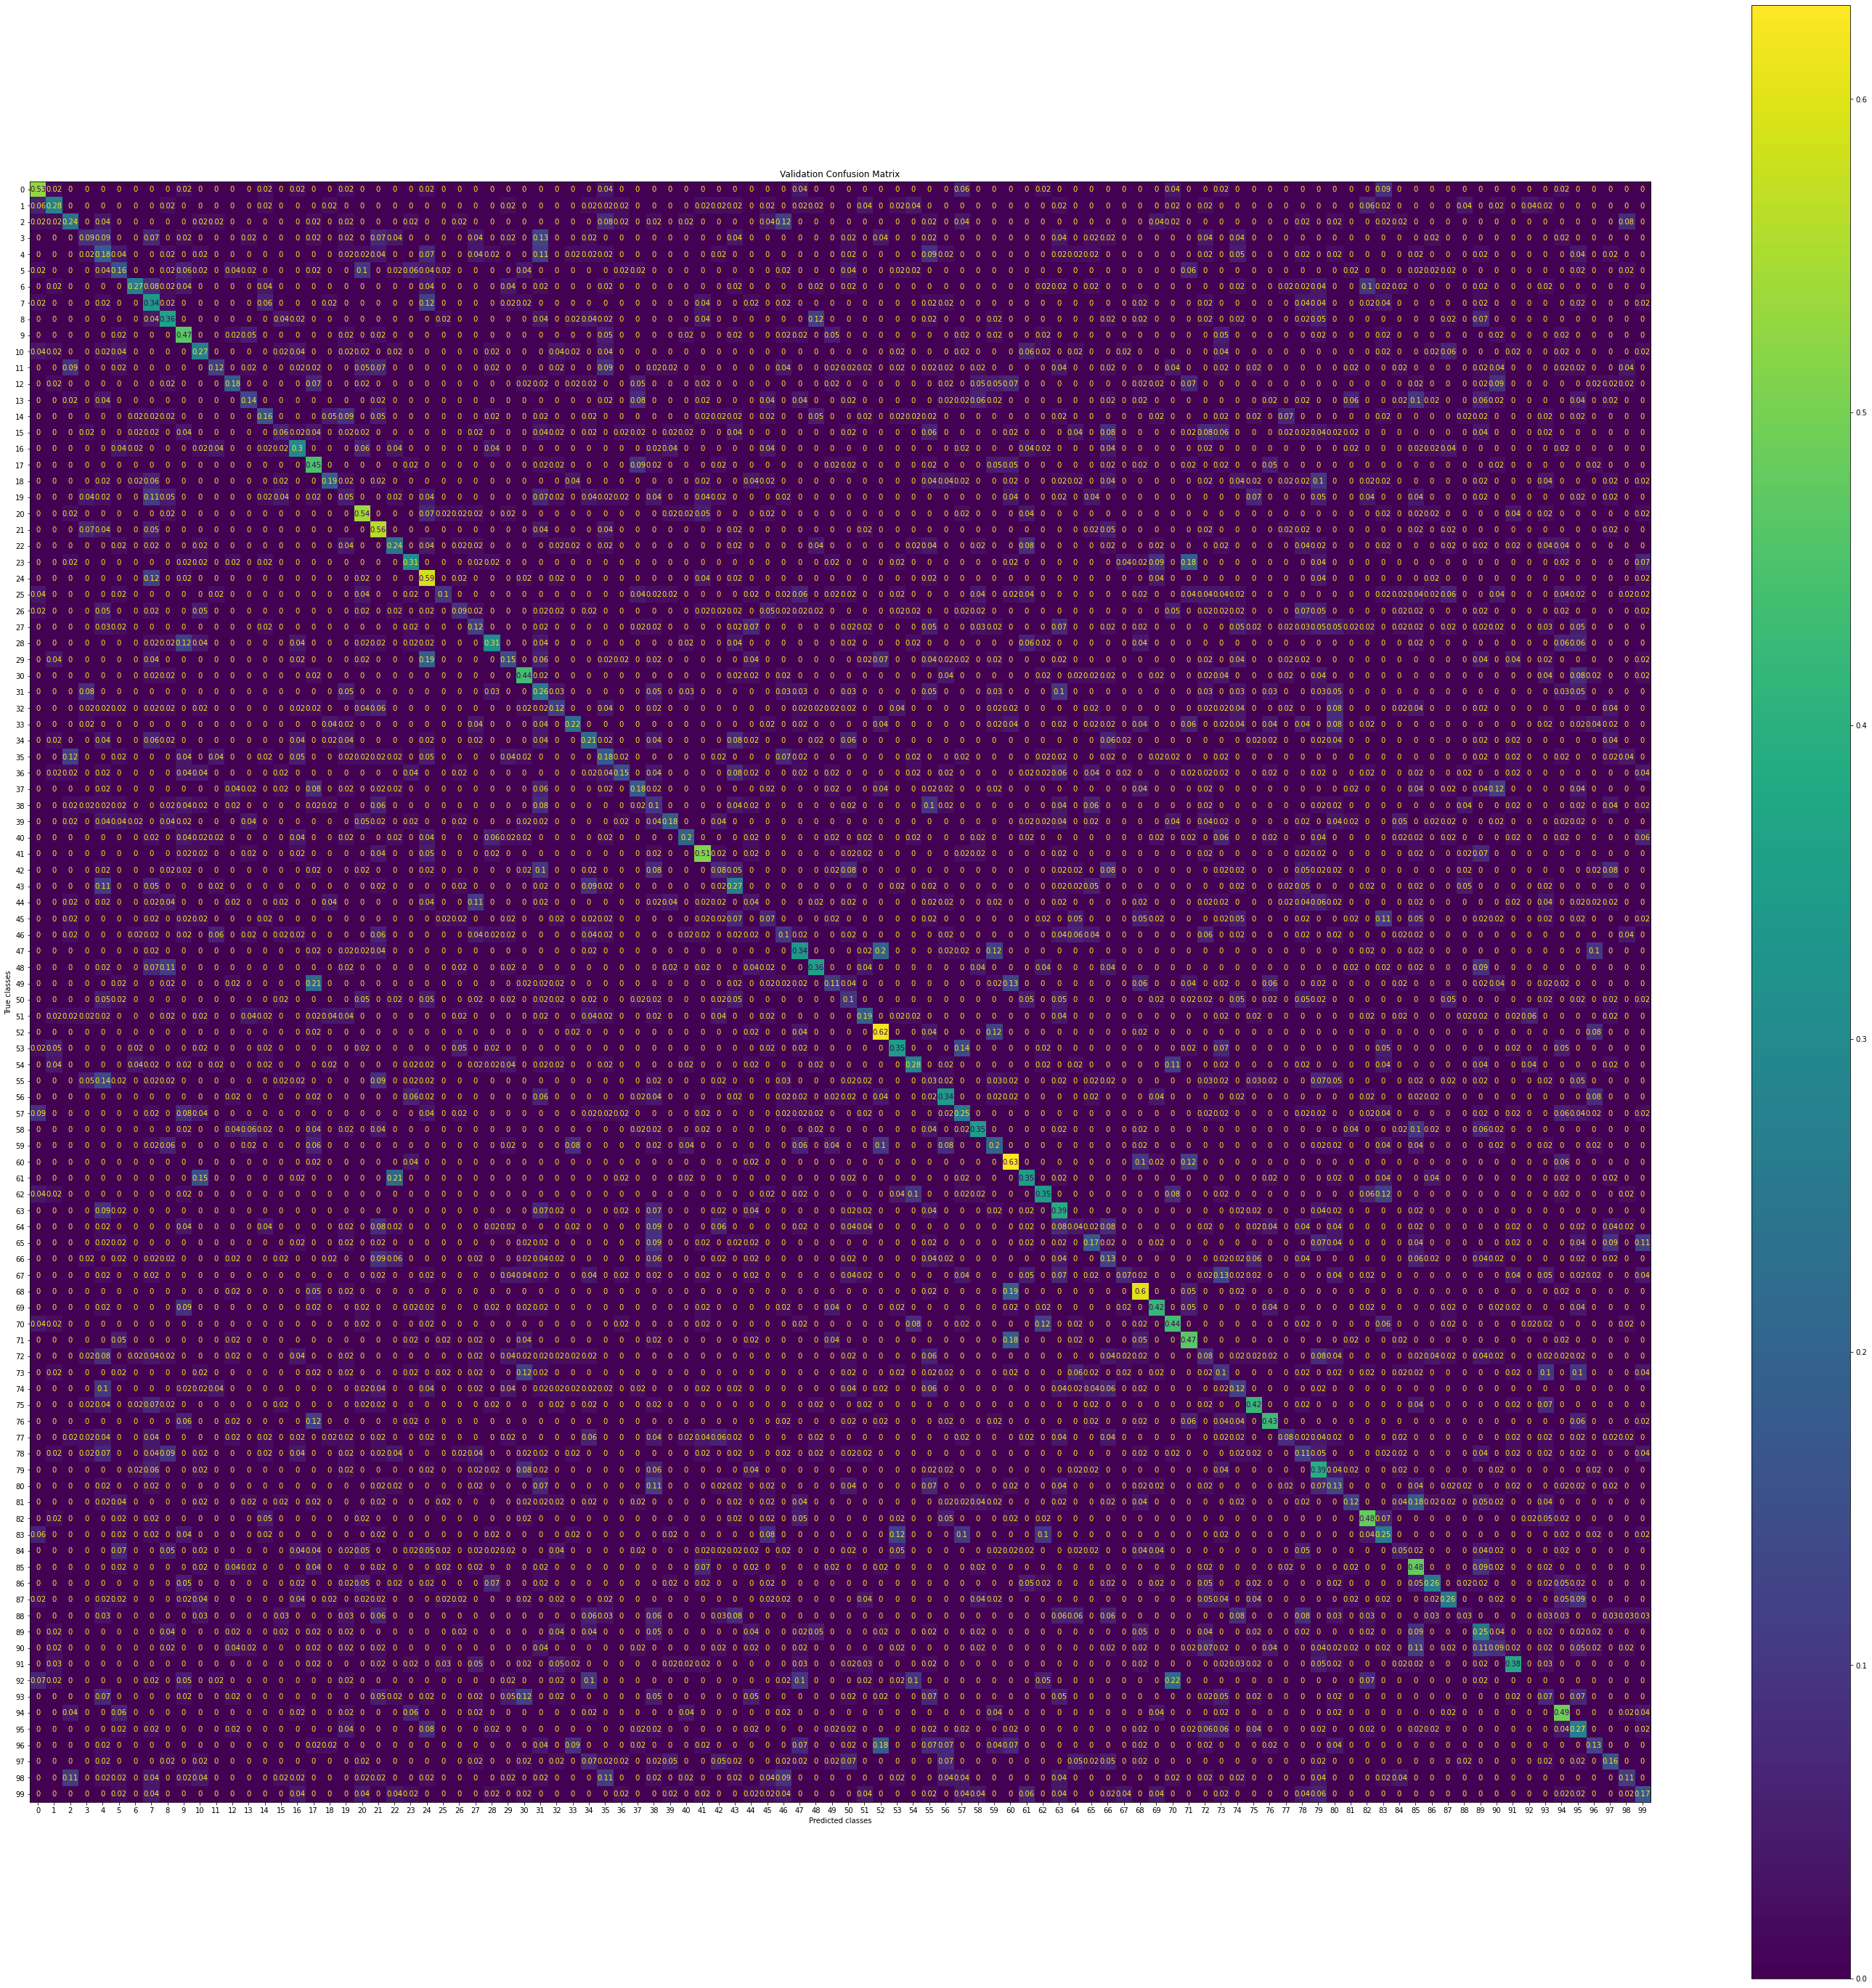

In [ ]:
#matriz confusion validación
from sklearn import metrics
# Se imprime accuracy
print("Validation accuracy:",metrics.accuracy_score(Y_val_b22.cpu().numpy(), Y_val_pred_b22.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_val_b22.cpu().numpy(), Y_val_pred_b22.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Validation Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()

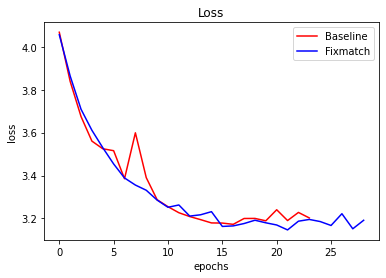

In [ ]:
# Gafico de perdidas baseline y fixmatch
plot_loss(val_loss21, val_loss22, NAME1 = 'Baseline', NAME2 = 'Fixmatch')

In [ ]:
#utilizar mejor modelo para el test
batch = 64
test_dataset = test_dataset100
best_red = best_model22
test_loss22, test_acc22, Y_test22, Y_test_pred22 = testear_Red(best_red, loss_function, test_dataset, batch, reports_every=1, device='cuda')

Testeando...Test_Loss:3.143%, Test_Acc:27.020%


Test accuracy: 0.2702


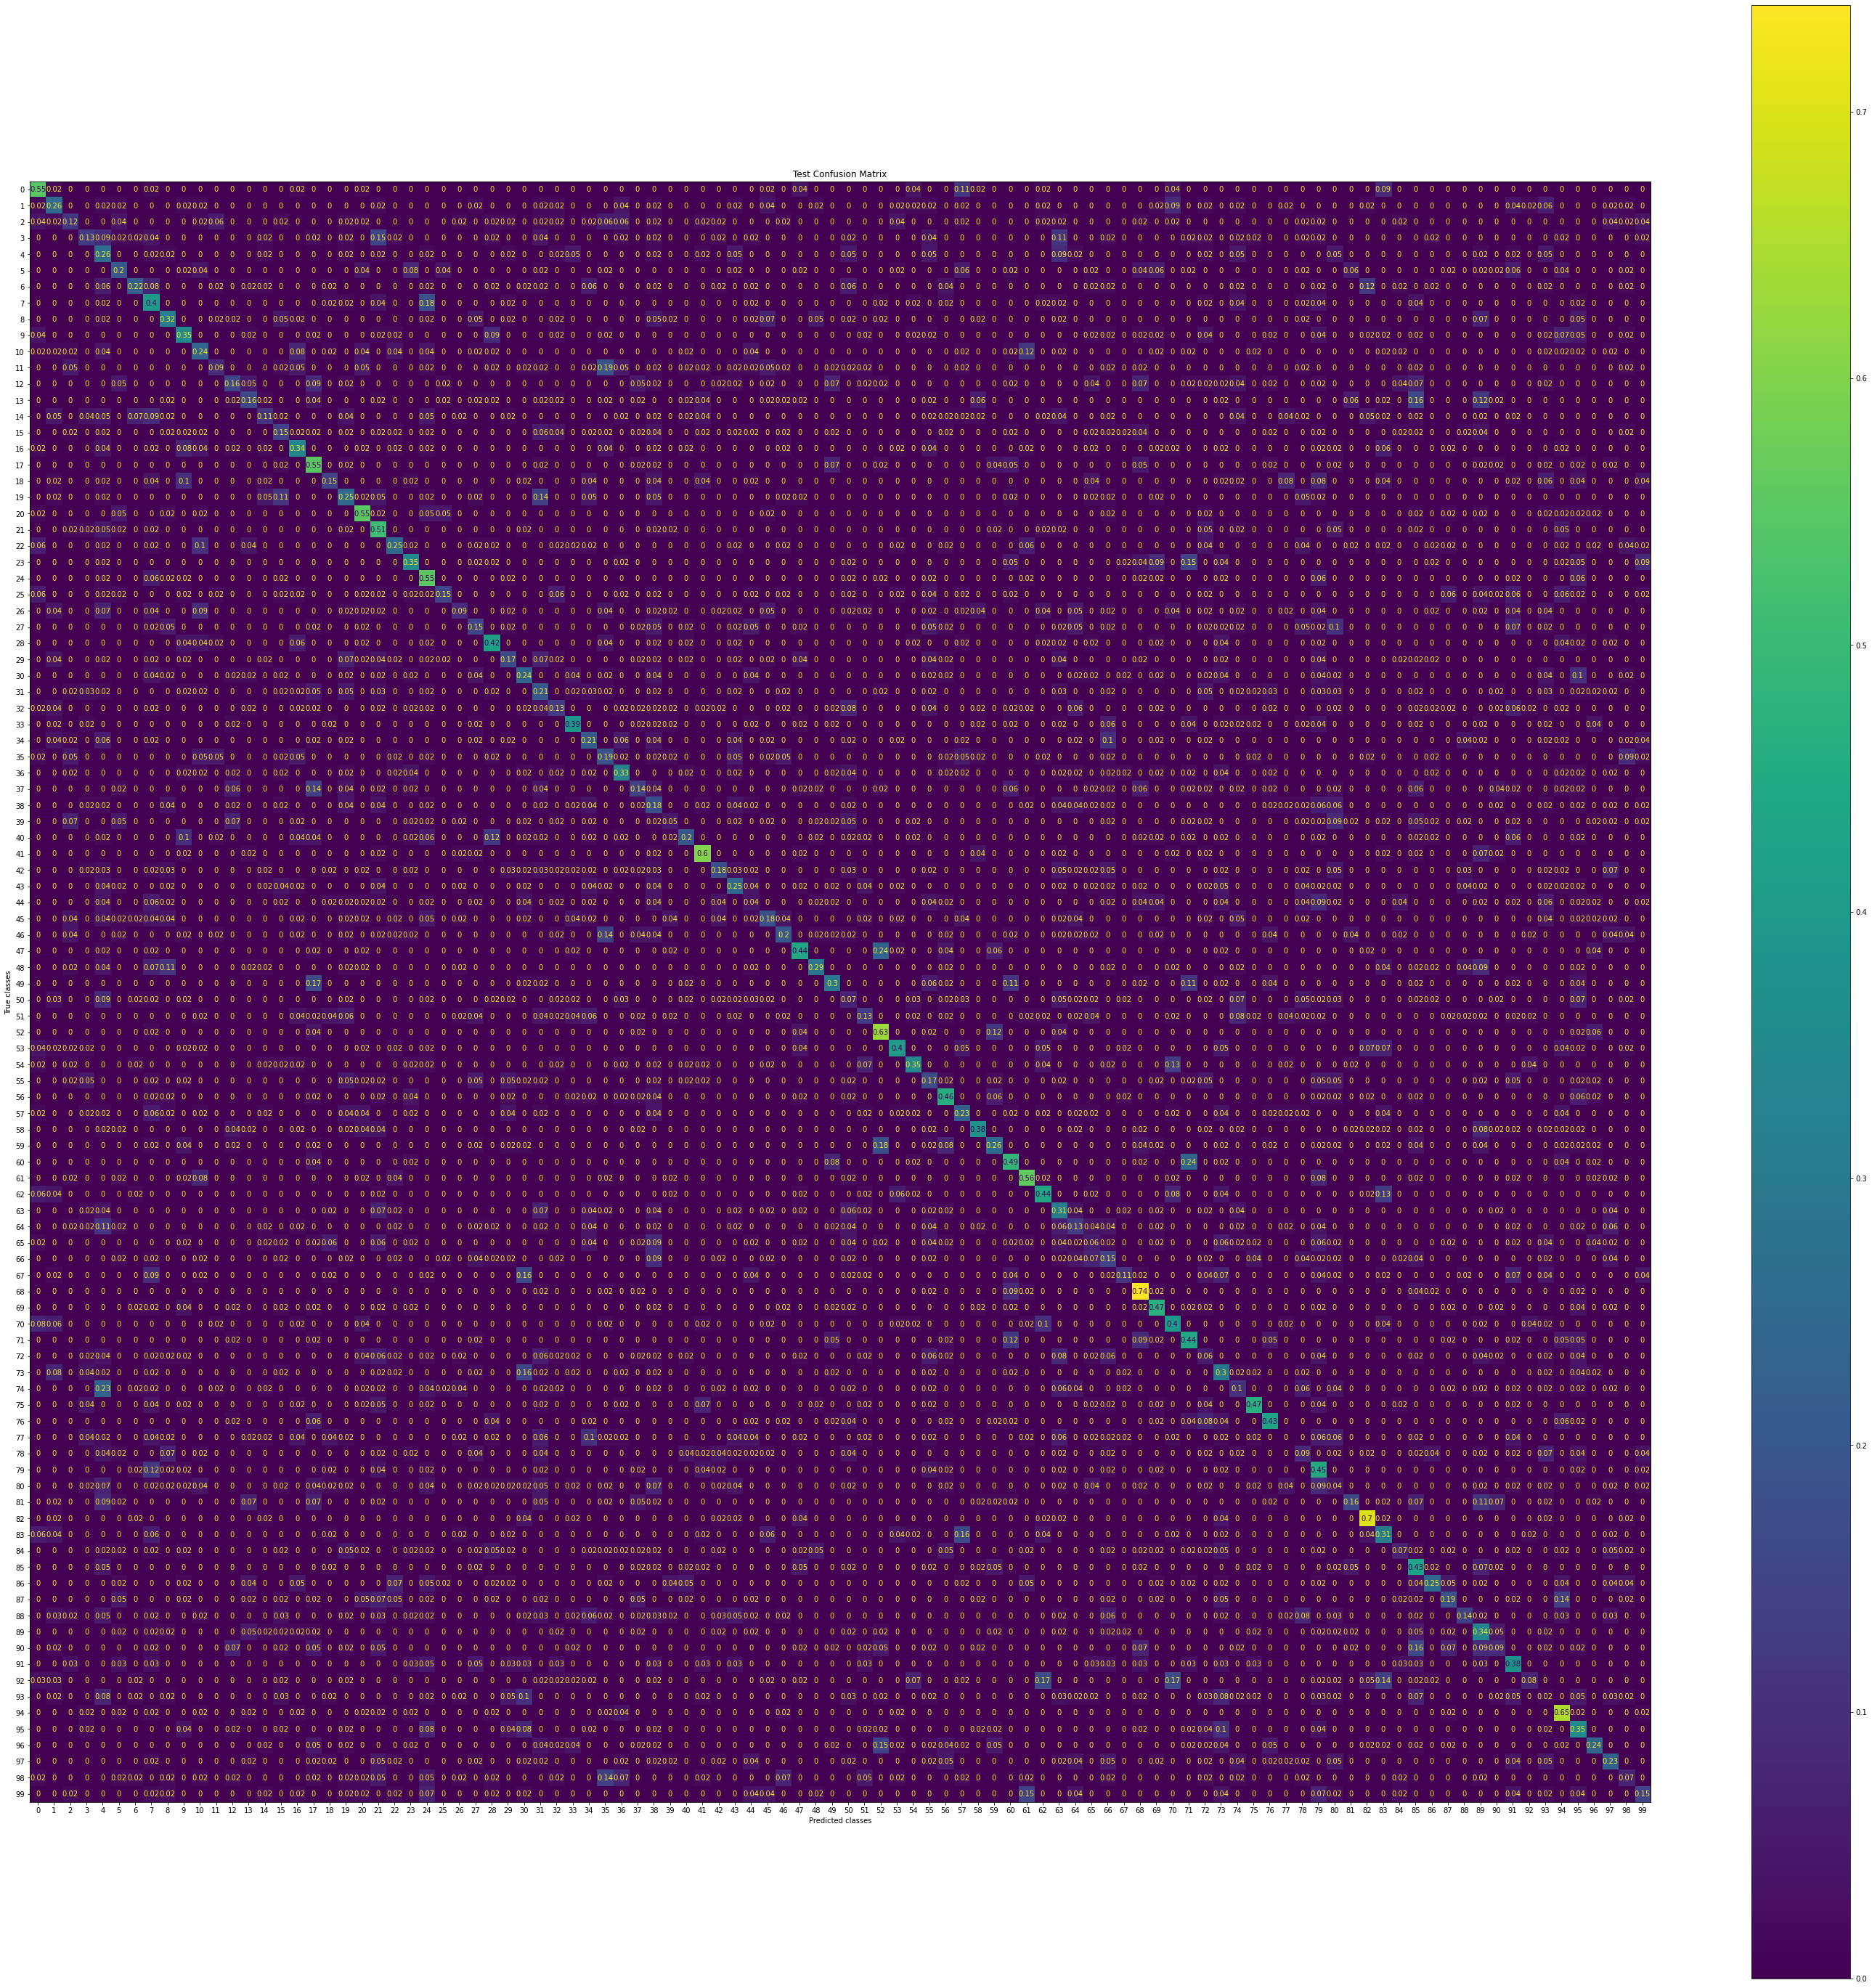

In [ ]:
#matriz confusion test

from sklearn import metrics
# Se imprime accuracy
print("Test accuracy:",metrics.accuracy_score(Y_test22.cpu().numpy(), Y_test_pred22.cpu().numpy()))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#se define la matriz de confusion
cm = confusion_matrix(Y_test22.cpu().numpy(), Y_test_pred22.cpu().numpy(), normalize='true')  
cm_round = np.round(cm, decimals = 2)
#se genera el display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_round)

fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)

disp.ax_.set(title='Test Confusion Matrix', xlabel='Predicted classes', ylabel='True classes')
#se muestra matriz
plt.show()